In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scanpy as sc
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [17]:
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl

In [18]:
import scipy
import random


In [7]:
# make GPU visible
os.environ["CUDA_VISIBLE_DEVICES"]="3"
torch.cuda.is_available()

True

In [4]:
import scipy.stats as stats

def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean, se = np.mean(data), stats.sem(data)
    margin_of_error = se * stats.t.ppf((1 + confidence) / 2, n - 1)
    print("margin of error: {}".format(margin_of_error))
    return round(mean - margin_of_error,2), round(mean,2), round(mean + margin_of_error,2)

In [5]:
def accuracy_confidence_interval(accuracy, num_predictions, confidence=0.95):
    SE = np.sqrt((accuracy * (1 - accuracy)) / num_predictions)
    z = stats.norm.ppf((1 + confidence) / 2)
    margin_of_error = z * SE
    lower_bound = accuracy - margin_of_error
    upper_bound = accuracy + margin_of_error
    return (round(lower_bound, 2), round(accuracy,2), round(upper_bound,2))

# dataset: LuCA (lung cancer atlas) -- explore metadata, prepare cell embeddings

### important notes on inclusion criteria and preprocessing of this data, from the orig publication:
### * "We did not exclude studies that applied flow cytometry-based cell-sorting prior to sequencing, as these incorporate relevant information on rare cell types."
### * We integrated the datasets using the scANVI algorithm
### * The Smart-seq2 counts were scaled by the gene length as recommended on the scvi-tools website. The scANVI model was initialized with a pre-trained scVI model, as recommended in the scvi-tools tutorial. The scVI model was trained on the 6000 most highly variable genes as determined with scanpy’s104 pp.highly_variable_genes with parameters flavor=”seurat_v3″ and batch_key=”dataset”
### * We computed UMAP embeddings and unsupervised Leiden-clustering with scanpy, based on a cell-cell neighborhood graph derived from scANVI latent space.

In [10]:
h5ad_path = "/data/rna_rep_learning/luca_salcher2022/04929c2b-00af-4adc-95ca-bd8ecc2abab2.h5ad"
luca_adata = sc.read_h5ad(h5ad_path)

In [11]:
luca_adata

AnnData object with n_obs × n_vars = 1283972 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts'

## explore metadata

In [21]:
# studies and assays
luca_adata.obs[['study','dataset','assay','origin','tissue']].drop_duplicates()

study  \
001C_AAACCTGCATCGGGTC-0                        Adams_Kaminski_2020   
AAACCCAAGAGCCATG-1_0-1                             Chen_Zhang_2020   
AAACCTGAGAGGTAGA-1_1-1                             Chen_Zhang_2020   
AAACCTGAGAGCTATA.2.NEC-2                     Goveia_Carmeliet_2020   
AAACCTGAGGACCACA.9.NEC-2                     Goveia_Carmeliet_2020   
TTC-204-0616P-3                                     Guo_Zhang_2018   
NTC41-0617-3                                        Guo_Zhang_2018   
F01157_AAACCTGGTGAACCTT-4                   Habermann_Kropski_2020   
AAACCTGAGAAACGCC_NS_13-5                              Kim_Lee_2020   
AAACCTGAGAAGGTGA_LUNG_N18-5                           Kim_Lee_2020   
AAACCTGAGACATAAC_LN_04-5                              Kim_Lee_2020   
AAACCTGAGACGACGT_LUNG_T34-5                           Kim_Lee_2020   
AAACCTGAGAGCAATT_EFFUSION_06-5                        Kim_Lee_2020   
AAACCTGAGAGGTTGC_BRONCHO_11-5                         Kim_Lee_2020   
AAACCTGAGACTGTAA-1_0-6                                 He_Fan_2021   
AAACCTGAGCTGCGAA-1_1-6                                 He_Fan_2021   
AACGGTACAAAAGC-1_0-7                     Lambrechts_Thienpont_2018   
AAACATACTCAGAC-1_2-7                     Lambrechts_Thienpont_2018   
AAACCTGCAACTGCGC-1_0-8                   Lambrechts_Thienpont_2018   
AAACCTGAGTAACCCT-1_1-8                   Lambrechts_Thienpont_2018   
AAACCTGCATTCTCAT-1_0-9                   Lambrechts_Thienpont_2018   
AAACCTGAGAGCCCAA-1_3-9                   Lambrechts_Thienpont_2018   
120703409633700_0-10                        Laughney_Massague_2020   
120703436406133_2-10                        Laughney_Massague_2020   
120703408819443_6-10                        Laughney_Massague_2020   
AAACCTGGTTGTGGCC-1-HCATisStab7509734-11       Madissoon_Meyer_2020   
SRR10794350-13                                 Maynard_Bivona_2020   
SRR10783827-13                                 Maynard_Bivona_2020   
SRR10779280-13                                 Maynard_Bivona_2020   
SRR10798194-13                                 Maynard_Bivona_2020   
SRR10791104-13                                 Maynard_Bivona_2020   
SRR10788488-13                                 Maynard_Bivona_2020   
SRR10781616-13                                 Maynard_Bivona_2020   
muc10380_CCGCCCCGTCAT-14                        Mayr_Schiller_2020   
AAACCTGAGCCGGTAA-1_1-15                      Reyfman_Misharin_2018   
A1_B002014.gencode.vH29-17                 Travaglini_Krasnow_2020   
593903_0-18                                                 UKIM-V   
83909_3-18                                                  UKIM-V   
ACATAGATAGGC-19                              Vieira_Teichmann_2019   
21_ACTCACCGCCAA-20                                    Wu_Zhou_2021   
bcFTPA_0-21                                    Zilionis_Klein_2019   
AAACCTGCACTACAGT-1-0-0                           Leader_Merad_2021   
AAACGGGAGATGTGGC-1-1-0                           Leader_Merad_2021   
AAACCTGAGACGCTTT-1-0-1                           Leader_Merad_2021   
AAACCTGAGCTCCTTC-1-1-1                           Leader_Merad_2021   
AAACCTGAGTGAACGC-1-0-2                           Leader_Merad_2021   
AAACCTGAGAATTGTG-1-1-2                           Leader_Merad_2021   
240865_0-3                                                  UKIM-V   
847830_1-3                                                  UKIM-V   
AAACCCAAGAAGAGCA-1-0-4                           Leader_Merad_2021   
AAACCTGAGAGTCTGG-1-0-5                           Leader_Merad_2021   
AAACCTGAGAGACTTA-1-1-5                           Leader_Merad_2021   
AAACATACGTACAC-1-0-6                             Leader_Merad_2021   
AAACCTGAGTTCGCGC-1-0-7                           Leader_Merad_2021   
AAACCTGAGTCAAGGC-1-1-7                           Leader_Merad_2021   
AAACCTGAGTCTCCTC-1-0-8                           Leader_Merad_2021   
AAACCTGAGCTAGTTC-1-1-8                           Leader_Merad_2021   



In [45]:
# studies and assays
luca_adata.obs[['sample','origin','tissue']].drop_duplicates()[['origin','tissue']].value_counts()

origin            tissue          
tumor_primary     lung                254
normal_adjacent   lung                137
normal            lung                 99
tumor_metastasis  lymph node           18
                  pleural effusion     12
                  brain                11
normal            lymph node           10
tumor_metastasis  lung                  5
                  liver                 5
                  adrenal tissue        3
nan               lung                  2
dtype: int64

### how much data exists for different outcomes of interest?

In [225]:
luca_adata.obs[['sample','uicc_stage']].drop_duplicates().uicc_stage.value_counts()

I             172
non-cancer    120
II             90
IV             76
III            55
III or IV      42
Name: uicc_stage, dtype: int64

In [26]:
#all of the stage 'III or IV' samples are from the study 'Wu_Zhou_2021' (and the study doesn't contain any other stages)
luca_adata.obs.loc[luca_adata.obs.uicc_stage=='III or IV',['study','dataset','assay','origin','tissue','uicc_stage']].drop_duplicates()
luca_adata.obs.loc[luca_adata.obs.dataset=='Wu_Zhou_2021',['study','dataset','assay','origin','tissue','uicc_stage']].drop_duplicates()

study       dataset                assay  \
21_ACTCACCGCCAA-20  Wu_Zhou_2021  Wu_Zhou_2021  GEXSCOPE technology   

                           origin tissue uicc_stage  
21_ACTCACCGCCAA-20  tumor_primary   lung  III or IV

In [30]:
luca_adata.obs[['sample','tumor_stage']].drop_duplicates().tumor_stage.value_counts()

early         262
advanced      173
non-cancer    120
Name: tumor_stage, dtype: int64

In [33]:
luca_adata.obs[['sample','tumor_stage','uicc_stage']].drop_duplicates()[['tumor_stage','uicc_stage']].value_counts()

tumor_stage  uicc_stage
early        I             172
non-cancer   non-cancer    120
early        II             90
advanced     IV             76
             III            55
             III or IV      42
dtype: int64

In [228]:
262/555

0.4720720720720721

In [113]:
# early = stage I or II; advanced = stage III or IV
luca_adata.obs[['sample','uicc_stage','tumor_stage']].drop_duplicates()[['uicc_stage','tumor_stage']].value_counts()

uicc_stage  tumor_stage
I           early          172
non-cancer  non-cancer     120
II          early           90
IV          advanced        76
III         advanced        55
III or IV   advanced        42
dtype: int64

In [196]:
luca_adata.obs[['sample','origin','tissue']].drop_duplicates()[['origin','tissue']].value_counts()

origin            tissue          
tumor_primary     lung                254
normal_adjacent   lung                137
normal            lung                 99
tumor_metastasis  lymph node           18
                  pleural effusion     12
                  brain                11
normal            lymph node           10
tumor_metastasis  lung                  5
                  liver                 5
                  adrenal tissue        3
nan               lung                  2
dtype: int64

In [231]:
len(luca_adata.obs[luca_adata.obs.cell_type == "malignant cell"]['sample'].drop_duplicates())

434

In [130]:
# development stage has same # unknowns as age
luca_adata.obs[['sample','development_stage']].drop_duplicates().development_stage.value_counts().head()

unknown                    106
74-year-old human stage     28
62-year-old human stage     24
70-year-old human stage     20
64-year-old human stage     20
Name: development_stage, dtype: int64

In [232]:
luca_adata.obs.disease.value_counts()

lung adenocarcinoma                      704834
normal                                   212889
squamous cell lung carcinoma             190199
non-small cell lung carcinoma            120796
chronic obstructive pulmonary disease     55254
Name: disease, dtype: int64

#### how many samples have non-missing info for columns of interest?

In [133]:
sample_col = 'sample'
for target_col in ["age", "uicc_stage", "origin", "tissue", 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation']:
    print(target_col)
    print("n not NA: ", (~luca_adata.obs[[sample_col,target_col]].drop_duplicates().isna()[target_col]).sum())
    print("% not NA: ", (~luca_adata.obs[[sample_col,target_col]].drop_duplicates().isna()[target_col]).sum()/len(luca_adata.obs[sample_col].drop_duplicates())*100)
    print("\n")

age
n not NA:  450
% not NA:  80.93525179856115


uicc_stage
n not NA:  555
% not NA:  99.82014388489209


origin
n not NA:  556
% not NA:  100.0


tissue
n not NA:  556
% not NA:  100.0


tumor_stage
n not NA:  555
% not NA:  99.82014388489209


EGFR_mutation
n not NA:  69
% not NA:  12.410071942446043


TP53_mutation
n not NA:  69
% not NA:  12.410071942446043


ALK_mutation
n not NA:  69
% not NA:  12.410071942446043


BRAF_mutation
n not NA:  69
% not NA:  12.410071942446043


ERBB2_mutation
n not NA:  69
% not NA:  12.410071942446043


KRAS_mutation
n not NA:  69
% not NA:  12.410071942446043


ROS_mutation
n not NA:  69
% not NA:  12.410071942446043




In [17]:
luca_adata.X.min()

0.0

In [18]:
luca_adata.X.max()

7.9258704

In [23]:
luca_adata.layers['count']

<1283972x17811 sparse matrix of type '<class 'numpy.float32'>'
	with 1755498280 stored elements in Compressed Sparse Row format>

In [20]:
luca_adata.layers['counts_length_scaled']

<1283972x17811 sparse matrix of type '<class 'numpy.float32'>'
	with 1751740316 stored elements in Compressed Sparse Row format>

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


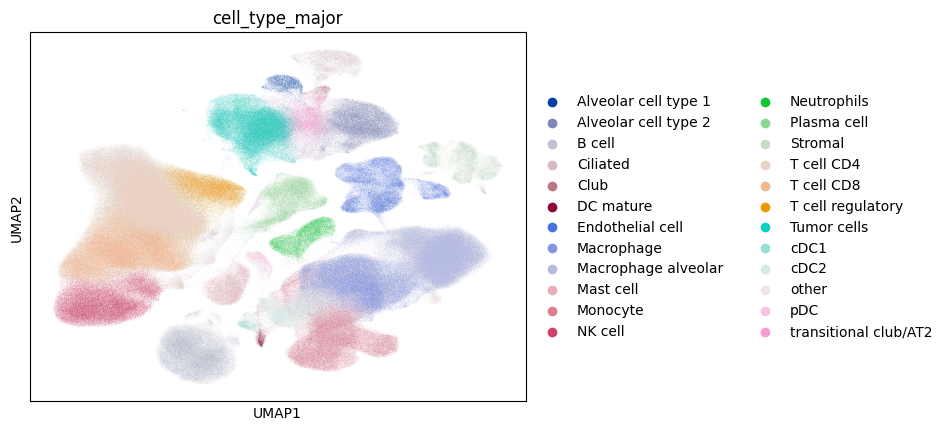

In [7]:
sc.pl.umap(luca_adata, color="cell_type_major")

In [149]:
len(luca_adata.obs.dataset.drop_duplicates())

29

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


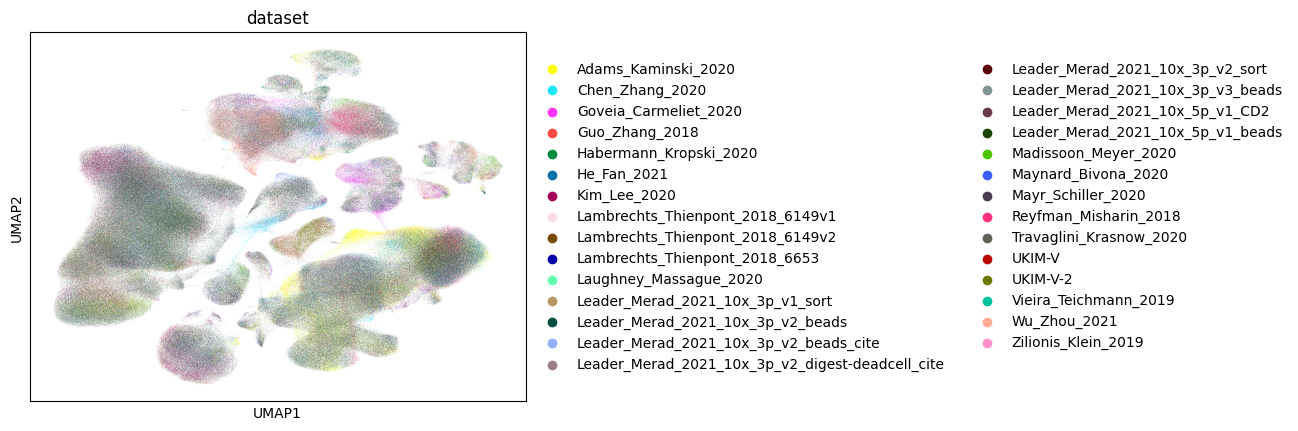

In [8]:
sc.pl.umap(luca_adata, color="dataset")

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


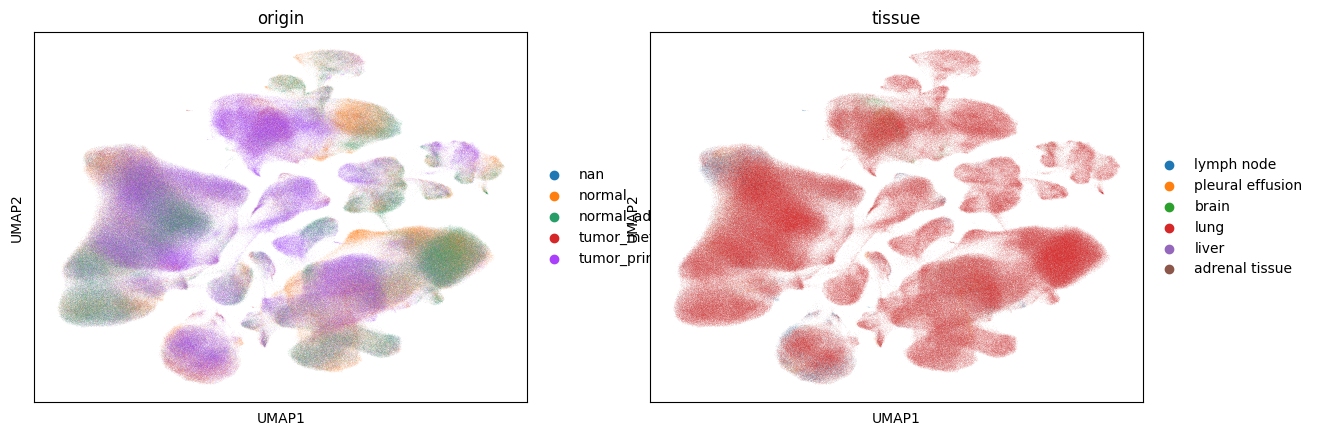

In [22]:
sc.pl.umap(luca_adata, color=["origin", "tissue"])

## is study correlated with outcome? then we would have a confounding factor and need to stratify train/test/val by study

### primary vs. metastatic biopsy

In [232]:
luca_adata.obs[['tumor_stage','dataset']]

tumor_stage                            dataset
001C_AAACCTGCATCGGGTC-0  non-cancer                Adams_Kaminski_2020
001C_AAACCTGTCAACACCA-0  non-cancer                Adams_Kaminski_2020
001C_AAACGGGAGACTAAGT-0  non-cancer                Adams_Kaminski_2020
001C_AAACGGGAGGCTCATT-0  non-cancer                Adams_Kaminski_2020
001C_AAACGGGAGGGAACGG-0  non-cancer                Adams_Kaminski_2020
...                             ...                                ...
TTTGTCACATCTATGG-1-38-8       early  Leader_Merad_2021_10x_3p_v2_beads
TTTGTCACATGTTGAC-1-38-8       early  Leader_Merad_2021_10x_3p_v2_beads
TTTGTCAGTGTTGGGA-1-38-8       early  Leader_Merad_2021_10x_3p_v2_beads
TTTGTCATCAGTTTGG-1-38-8       early  Leader_Merad_2021_10x_3p_v2_beads
TTTGTCATCTCGGACG-1-38-8       early  Leader_Merad_2021_10x_3p_v2_beads

[1283972 rows x 2 columns]

### age

### stage: early vs. advanced

## embed LuCA cells using scGPT

In [12]:
import scgpt as scg
import sys
from pathlib import Path

In [13]:
model_dir = Path("/data/rna_rep_learning/scGPT/scGPT_human")

In [14]:
# scGPT code assumes counts are stored in X, so move things around accordingly
luca_adata.layers['lognorm'] = luca_adata.X.copy()
luca_adata.X = luca_adata.layers['count']

In [15]:
luca_adata.X.max()

7972410.0

In [16]:
luca_adata

AnnData object with n_obs × n_vars = 1283972 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts'

In [17]:
luca_adata.X

<1283972x17811 sparse matrix of type '<class 'numpy.float32'>'
	with 1755498280 stored elements in Compressed Sparse Row format>

In [18]:
luca_adata = scg.tasks.embed_data(
    luca_adata,
    model_dir,
    gene_col="feature_name",
    #obs_to_save=adata.obs.columns,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=False,
)

scGPT - INFO - match 17811/17811 genes in vocabulary of size 60697.


Embedding cells: 100%|█████████████████████████████████████████████████████████████████████████████| 20063/20063 [24:56<00:00, 13.41it/s]
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


In [19]:
#save this new adata
luca_adata.write("/data/rna_rep_learning/luca_salcher2022/luca_w_scGPT_embeds.h5ad")

In [6]:
luca_adata = sc.read_h5ad("/data/rna_rep_learning/luca_salcher2022/luca_w_scGPT_embeds.h5ad")

### Check that these scGPT embeddings look reasonable

In [ ]:
sc.pp.neighbors(luca_adata, use_rep="X_scGPT")

In [ ]:
sc.tl.umap(luca_adata)
sc.pl.umap(luca_adata, color="cell_type_major")

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


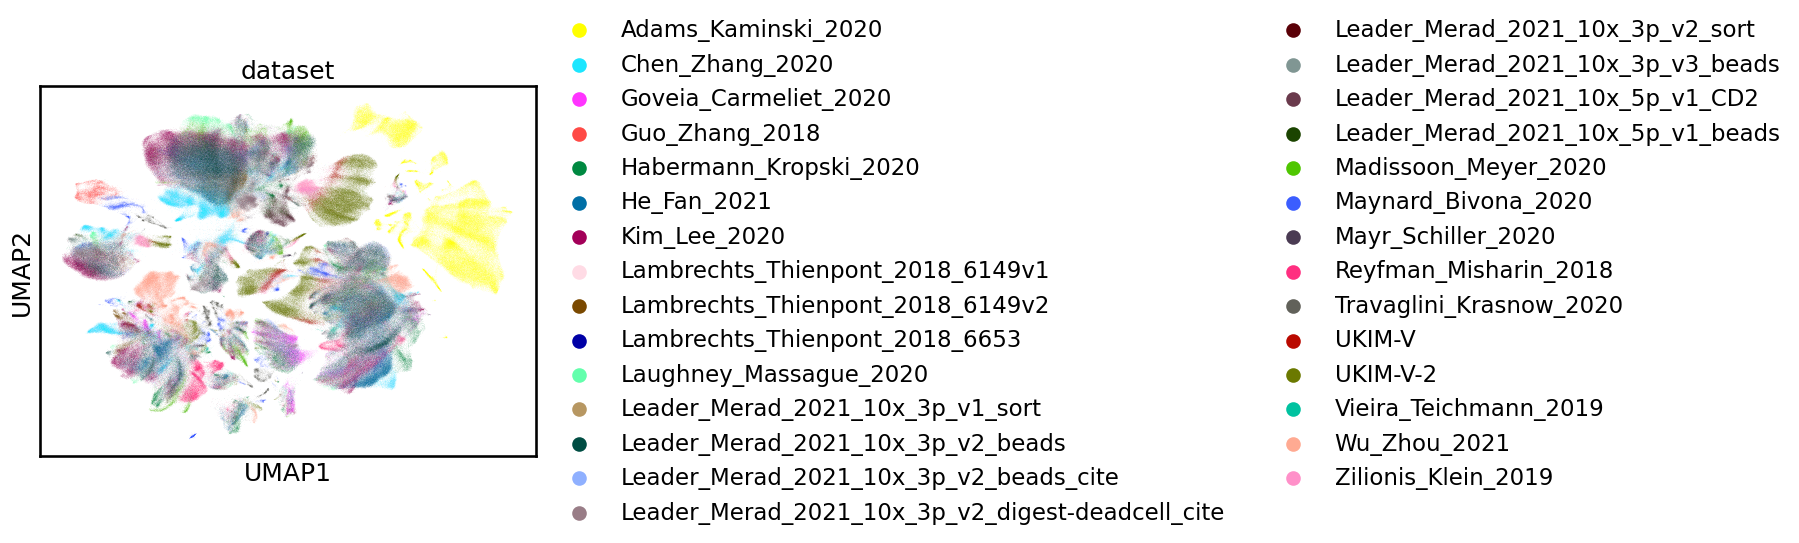

In [224]:
sc.pl.umap(luca_adata, color="dataset")

# predicting age - using all cells

#### explore whether it is important that we stratify train test split by study -- don't think very important, since the study isn't highly correlated with the outcome of interest (age, see boxplot)

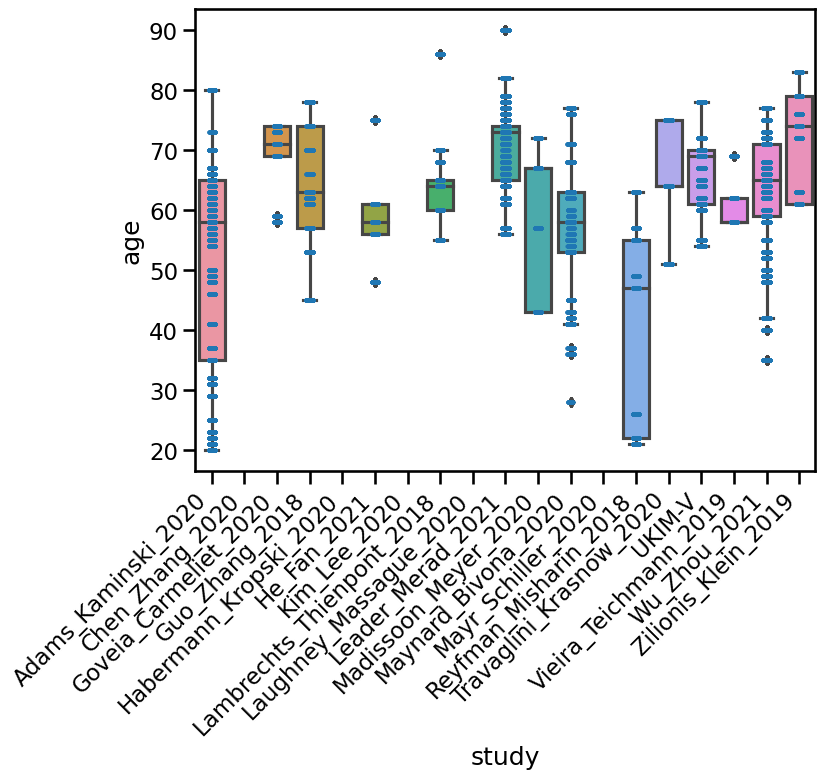

In [240]:
# is age correlated with study?
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.boxplot(data=luca_adata.obs, x="study", y="age");
sns.stripplot(data=luca_adata.obs, x="study", y="age", size=3);
plt.xticks(rotation=45, ha='right');

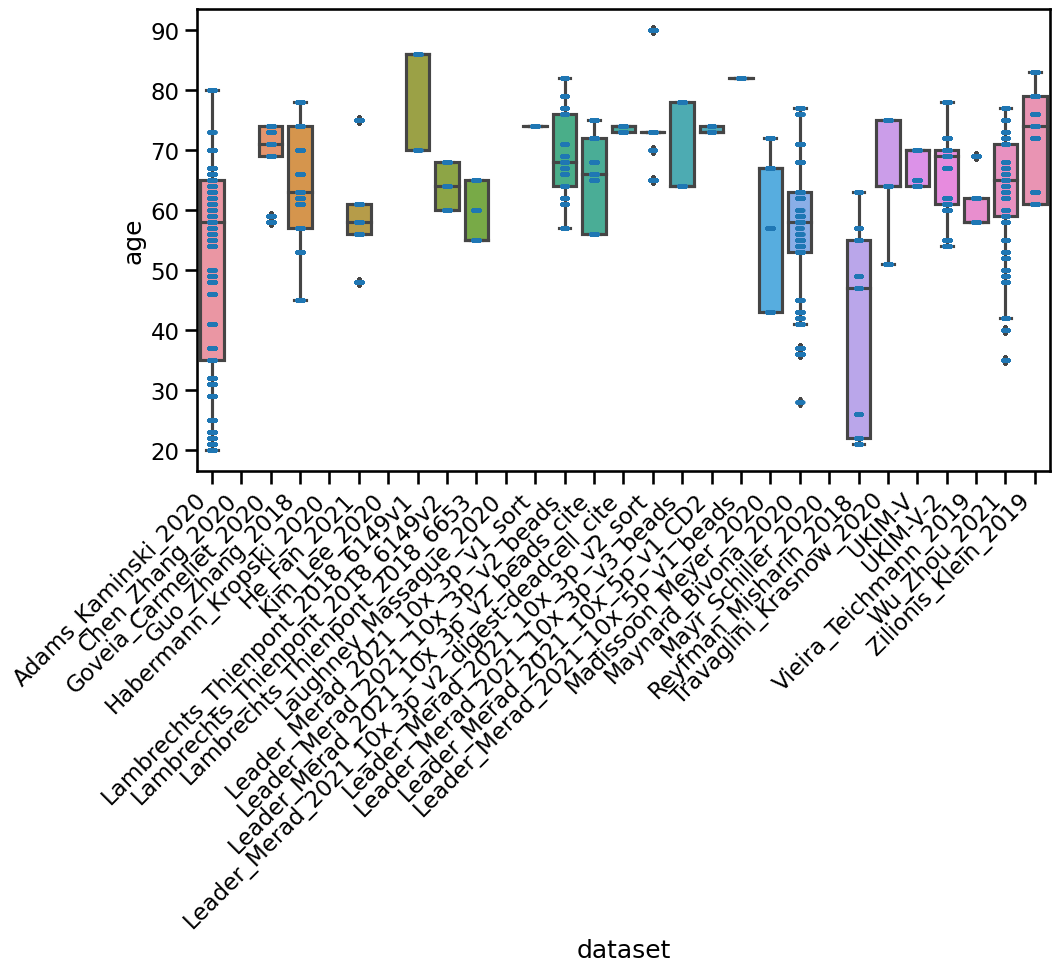

In [241]:
# is age correlated with study?
import seaborn as sns
plt.figure(figsize=(11, 6))
sns.boxplot(data=luca_adata.obs, x="dataset", y="age");
sns.stripplot(data=luca_adata.obs, x="dataset", y="age", size=3);
plt.xticks(rotation=45, ha='right');

In [328]:
sample_col = 'sample'
target_col = 'age'


(array([  9.,  10.,   8.,  21.,  30.,  89., 129., 104.,  41.,   9.]),
 array([20., 27., 34., 41., 48., 55., 62., 69., 76., 83., 90.]),
 <BarContainer object of 10 artists>)

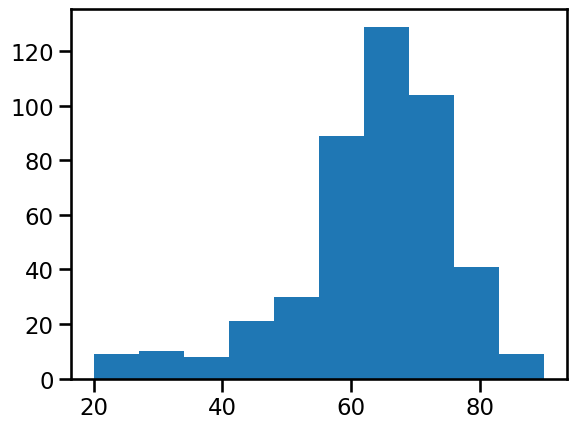

In [329]:
plt.hist(luca_adata.obs[[sample_col, target_col]].drop_duplicates()[target_col])

In [330]:
#get sample IDs that are not NA for this target
notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~pd.isna(luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col])]
print("this target has {} non-NA samples".format(len(notNA_samples)))

this target has 450 non-NA samples


In [331]:
sample_pool = notNA_samples #np.intersect1d(tumor_cell_samples, notNA_samples)

In [332]:
## Define targets
targets = luca_adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]

In [333]:
#70/15/15 split
from sklearn.model_selection import train_test_split
trainvalsamples, test_samples= train_test_split(sample_pool, test_size=0.15, random_state=18)
train_samples, val_samples = train_test_split(trainvalsamples, test_size=0.15/0.85, random_state=18)
del trainvalsamples

In [334]:
print(len(train_samples))
print(len(val_samples))
print(len(test_samples))

314
68
68


In [337]:
# set targets for each split
train_targets = torch.tensor(targets.loc[train_samples], dtype=torch.uint8)
val_targets = torch.tensor(targets.loc[val_samples], dtype=torch.uint8)
test_targets = torch.tensor(targets.loc[test_samples], dtype=torch.uint8)

## heuristic baselines

### mean age as baseline

In [346]:
# validate MAE, MSE
val_avg_errors = torch.abs(val_targets - train_targets.float().mean().item())
print("MAE ", torch.mean(val_avg_errors))
print("MSE ", torch.mean(val_avg_errors**2))
confidence_interval(val_avg_errors.numpy())

MAE  tensor(9.2919)
MSE  tensor(154.4570)
margin of error: 2.0125951957732258


(7.28, 9.29, 11.3)

In [347]:
# test MAE, MSE
test_avg_errors = torch.abs(test_targets - train_targets.float().mean().item())
print("MAE ", torch.mean(test_avg_errors))
print("MSE ", torch.mean(test_avg_errors**2))
confidence_interval(test_avg_errors.numpy())

MAE  tensor(10.6928)
MSE  tensor(219.2446)
margin of error: 2.4976516917982634


(8.2, 10.69, 13.19)

### mean age per dataset as baseline

In [281]:
mean_age = luca_adata.obs.loc[:, [sample_col, target_col, 'dataset']].drop_duplicates().set_index(sample_col).loc[train_samples].groupby('dataset').mean('age').dropna().mean()
baseline_preds = luca_adata.obs.loc[:, [sample_col, target_col, 'dataset']].drop_duplicates().set_index(sample_col).loc[train_samples].groupby('dataset').mean('age').fillna(mean_age).reset_index().rename(columns={'age':'predicted_age'})

In [294]:
val_baseline_res = luca_adata.obs.loc[:, [sample_col, target_col, 'dataset']].drop_duplicates().set_index('sample').loc[val_samples,:].reset_index().merge(baseline_preds, on="dataset", how="right").set_index('sample').loc[val_samples,:]
val_avg_errors = np.absolute(val_baseline_res.age - val_baseline_res.predicted_age)
print("MAE ", np.mean(val_avg_errors))
print("MSE ", np.mean(val_avg_errors**2))                      

MAE  8.576571234554429
MSE  125.17311048698465


In [297]:
confidence_interval(val_avg_errors)

margin of error: 1.75192365011247


(6.8246475844419585, 8.576571234554429, 10.328494884666899)

In [293]:
confidence_interval(test_avg_errors)

(7.402866422150704, 9.153499733226626, 10.904133044302547)

## create dataloader and train on scANVI embeddings

In [256]:
emb_name = 'X_scANVI'
input_size = luca_adata.obsm[emb_name].shape[1]

#get sample IDs that are not NA for this target
#notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
#print("this target has {} non-NA samples".format(len(notNA_samples)))

## Input
# in this case, limiting pseudobulk input to only contain tumor cells
pseudobulk_input = pd.DataFrame(luca_adata.obsm[emb_name], index=luca_adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

## Create train, val, test datasets
train_input = pseudobulk_input.loc[train_samples,:].dropna()
val_input = pseudobulk_input.loc[val_samples,:].dropna()
test_input = pseudobulk_input.loc[test_samples,:].dropna()

train_targets = torch.tensor(targets.loc[train_samples], dtype=torch.uint8)
val_targets = torch.tensor(targets.loc[val_samples], dtype=torch.uint8)
test_targets = torch.tensor(targets.loc[test_samples], dtype=torch.uint8)

train_dataset = TensorDataset(torch.Tensor(np.array(train_input)), train_targets)
val_dataset = TensorDataset(torch.Tensor(np.array(val_input)), val_targets)
test_dataset = TensorDataset(torch.Tensor(np.array(test_input)), test_targets)

## Create DataLoader for each split
#train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=True)

### KNN

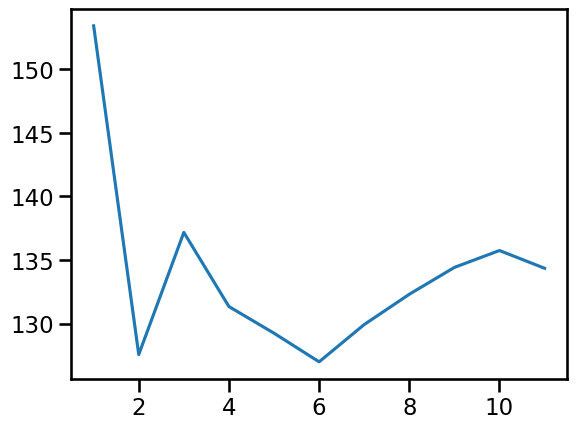

In [194]:
## train KNN
val_maes = []
val_mses = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_mae = mean_absolute_error(val_dataset[:][1], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(val_dataset[:][1], preds)
    val_mses.append(val_mse)
plt.plot(Ks, val_mses)
    #print("val acc ", val_acc)
    #print("val AUC ", roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    #print("\n")



In [195]:
bestk = Ks[np.argmin(val_mses)]
print("best K = ", bestk)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = KNeighborsRegressor(n_neighbors=bestk)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test MAE: ", mean_absolute_error(test_dataset[:][1], preds))
print("test MSE: ", mean_squared_error(test_dataset[:][1], preds))

best K =  6
val MAE:  8.784313725490197
val MSE:  126.98774509803921
test MAE:  9.17156862745098
test MSE:  163.0326797385621


### linear regression 

In [204]:
## train KNN
val_maes = []
val_mses = []

neigh = LinearRegression()
neigh.fit(train_dataset[:][0], train_dataset[:][1])

preds = neigh.predict(val_dataset[:][0])
print("val MAE: ", mean_absolute_error(val_dataset[:][1], preds))
print("val MSE: ", mean_squared_error(val_dataset[:][1], preds))

preds = neigh.predict(test_dataset[:][0])
print("test MAE: ", mean_absolute_error(test_dataset[:][1], preds))
print("test MSE: ", mean_squared_error(test_dataset[:][1], preds))

val MAE:  9.580316
val MSE:  145.76549
test MAE:  9.240057
test MSE:  163.63387


### l1 logistic regression

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.365e+03, tolerance: 4.474e+00
  model = cd_fast.enet_coordinate_descent(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.676e+03, tolerance: 4.474e+00
  model = cd_fast.enet_coordinate_descent(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

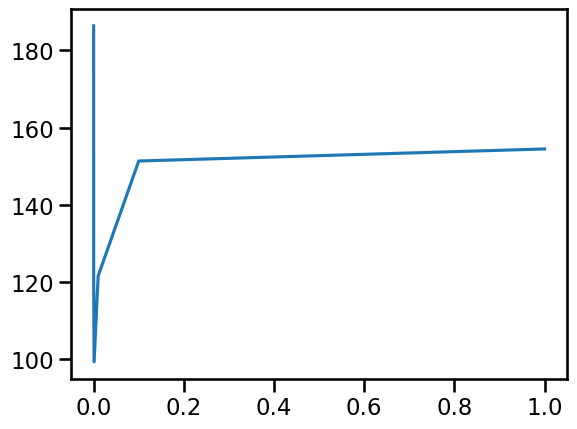

In [224]:
## train KNN
val_maes = []
val_mses = []
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
for alpha in alphas:
    neigh = Lasso(alpha=alpha)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_mae = mean_absolute_error(val_dataset[:][1], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(val_dataset[:][1], preds)
    val_mses.append(val_mse)
plt.plot(alphas, val_mses)

In [225]:
bestalpha = alphas[np.argmin(val_mses)]
print("best alpha = ", bestalpha)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = Lasso(alpha=bestalpha)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test MAE: ", mean_absolute_error(test_dataset[:][1], preds))
print("test MSE: ", mean_squared_error(test_dataset[:][1], preds))

best alpha =  0.001
val MAE:  8.098052976755055
val MSE:  99.23125432328561
test MAE:  10.251207359074337
test MSE:  180.11571720865956


/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.927e+02, tolerance: 4.474e+00
  model = cd_fast.enet_coordinate_descent(


### random forest

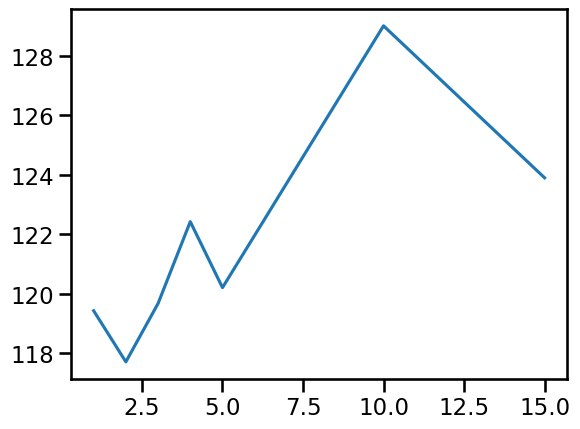

In [211]:
val_maes = []
val_mses = []
Cs = [1,2,3,4,5,10,15]
for c in Cs:
    neigh = RandomForestRegressor(min_samples_leaf=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_mae = mean_absolute_error(val_dataset[:][1], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(val_dataset[:][1], preds)
    val_mses.append(val_mse)

plt.plot(Cs, val_mses)

In [212]:
bestc = Cs[np.argmin(val_mses)]
print("best min_samples_leaf = ", bestc)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = RandomForestRegressor(min_samples_leaf=bestc)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test MAE: ", mean_absolute_error(test_dataset[:][1], preds))
print("test MSE: ", mean_squared_error(test_dataset[:][1], preds))

best min_samples_leaf =  2
val MAE:  8.424951776165011
val MSE:  117.70359527588444
test MAE:  9.004754769331974
test MSE:  154.7441001349358


## create dataloader and train on scGPT embeddings

In [223]:
emb_name = 'X_scGPT'
input_size = luca_adata.obsm[emb_name].shape[1]

#get sample IDs that are not NA for this target
#notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
#print("this target has {} non-NA samples".format(len(notNA_samples)))

## Input
# in this case, limiting pseudobulk input to only contain tumor cells
pseudobulk_input = pd.DataFrame(luca_adata.obsm[emb_name], index=luca_adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

## Create train, val, test datasets
train_input = pseudobulk_input.loc[train_samples,:].dropna()
val_input = pseudobulk_input.loc[val_samples,:].dropna()
test_input = pseudobulk_input.loc[test_samples,:].dropna()

train_targets = torch.tensor(targets.loc[train_samples], dtype=torch.uint8)
val_targets = torch.tensor(targets.loc[val_samples], dtype=torch.uint8)
test_targets = torch.tensor(targets.loc[test_samples], dtype=torch.uint8)

train_dataset = TensorDataset(torch.Tensor(np.array(train_input)), train_targets)
val_dataset = TensorDataset(torch.Tensor(np.array(val_input)), val_targets)
test_dataset = TensorDataset(torch.Tensor(np.array(test_input)), test_targets)

## Create DataLoader for each split
#train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=True)

### KNN

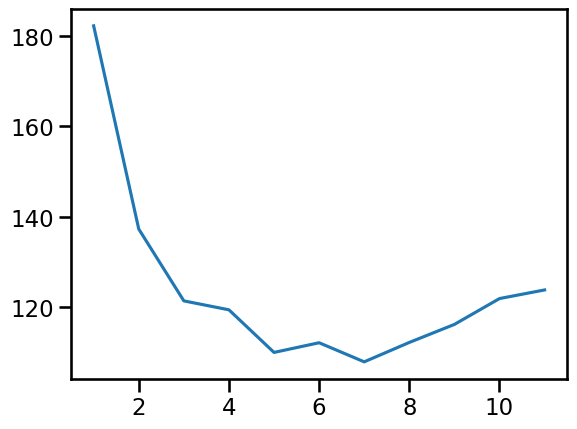

In [214]:
## train KNN
val_maes = []
val_mses = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_mae = mean_absolute_error(val_dataset[:][1], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(val_dataset[:][1], preds)
    val_mses.append(val_mse)
plt.plot(Ks, val_mses)

In [215]:
bestk = Ks[np.argmin(val_mses)]
print("best K = ", bestk)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = KNeighborsRegressor(n_neighbors=bestk)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test MAE: ", mean_absolute_error(test_dataset[:][1], preds))
print("test MSE: ", mean_squared_error(test_dataset[:][1], preds))

best K =  7
val MAE:  7.859243697478994
val MSE:  107.87304921968789
test MAE:  9.302521008403362
test MSE:  152.81812725090037


### linear regression 

In [216]:
## train KNN
val_maes = []
val_mses = []

neigh = LinearRegression()
neigh.fit(train_dataset[:][0], train_dataset[:][1])

preds = neigh.predict(val_dataset[:][0])
print("val MAE: ", mean_absolute_error(val_dataset[:][1], preds))
print("val MSE: ", mean_squared_error(val_dataset[:][1], preds))

preds = neigh.predict(test_dataset[:][0])
print("test MAE: ", mean_absolute_error(test_dataset[:][1], preds))
print("test MSE: ", mean_squared_error(test_dataset[:][1], preds))

val MAE:  15.698891
val MSE:  452.88422
test MAE:  17.73551
test MSE:  729.59937


### lasso

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.365e+03, tolerance: 4.474e+00
  model = cd_fast.enet_coordinate_descent(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.676e+03, tolerance: 4.474e+00
  model = cd_fast.enet_coordinate_descent(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

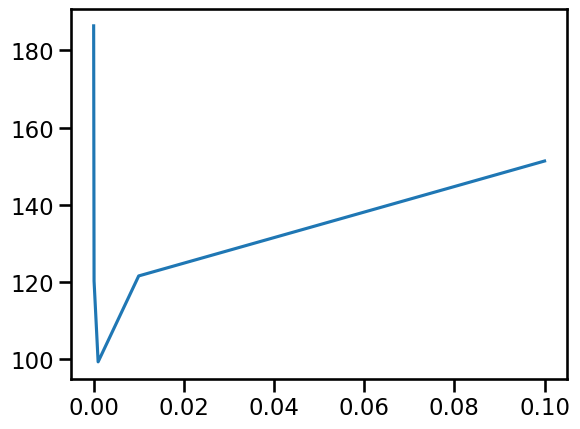

In [219]:
## train KNN
val_maes = []
val_mses = []
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
for alpha in alphas:
    neigh = Lasso(alpha=alpha)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_mae = mean_absolute_error(val_dataset[:][1], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(val_dataset[:][1], preds)
    val_mses.append(val_mse)
plt.plot(alphas, val_mses)

In [220]:
bestalpha = alphas[np.argmin(val_mses)]
print("best alpha = ", bestalpha)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = Lasso(alpha=bestalpha)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test MAE: ", mean_absolute_error(test_dataset[:][1], preds))
print("test MSE: ", mean_squared_error(test_dataset[:][1], preds))

best alpha =  0.001
val MAE:  8.098052976755055
val MSE:  99.23125432328561
test MAE:  10.251207359074337
test MSE:  180.11571720865956


/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.927e+02, tolerance: 4.474e+00
  model = cd_fast.enet_coordinate_descent(


### random forest

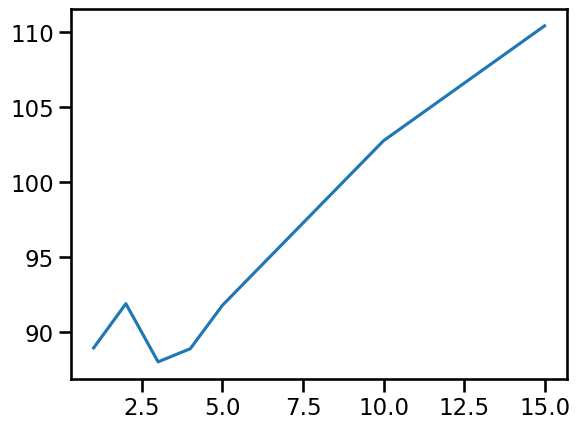

In [221]:
val_maes = []
val_mses = []
Cs = [1,2,3,4,5,10,15]
for c in Cs:
    neigh = RandomForestRegressor(min_samples_leaf=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_mae = mean_absolute_error(val_dataset[:][1], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(val_dataset[:][1], preds)
    val_mses.append(val_mse)

plt.plot(Cs, val_mses)

In [222]:
bestc = Cs[np.argmin(val_mses)]
print("best min_samples_leaf = ", bestc)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = RandomForestRegressor(min_samples_leaf=bestc)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test MAE: ", mean_absolute_error(test_dataset[:][1], preds))
print("test MSE: ", mean_squared_error(test_dataset[:][1], preds))

best min_samples_leaf =  3
val MAE:  7.248628454878455
val MSE:  88.03271521962427
test MAE:  8.795739813291286
test MSE:  159.3219998189259


## create dataloader and train on fraction of each cell type

In [270]:
# inspect all the different cell type columns to decide which is the best to use. using "cell_type"
#luca_adata.obs[["ann_fine",  "cell_type",'cell_type_major']].value_counts() #"cell_type_predicted",'ann_coarse',  'cell_type_tumor',, 'cell_type_neutro','cell_type_neutro_coarse'

In [219]:
input_size = len(luca_adata.obs.cell_type.cat.categories)

## Input
celltype_counts_df = pd.DataFrame(luca_adata.obs.groupby('sample').cell_type.value_counts()).rename({'cell_type':'cell_type_counts'},axis=1).reset_index().pivot(index="sample", columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)

## Create train, val, test datasets
train_input = celltype_fracs_df.loc[train_samples,:].dropna()
val_input = celltype_fracs_df.loc[val_samples,:].dropna()
test_input = celltype_fracs_df.loc[test_samples,:].dropna()

train_targets = torch.tensor(targets.loc[train_samples], dtype=torch.uint8)
val_targets = torch.tensor(targets.loc[val_samples], dtype=torch.uint8)
test_targets = torch.tensor(targets.loc[test_samples], dtype=torch.uint8)

train_dataset = TensorDataset(torch.Tensor(np.array(train_input)), train_targets)
val_dataset = TensorDataset(torch.Tensor(np.array(val_input)), val_targets)
test_dataset = TensorDataset(torch.Tensor(np.array(test_input)), test_targets)

## Create DataLoader for each split
#train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=True)

### KNN

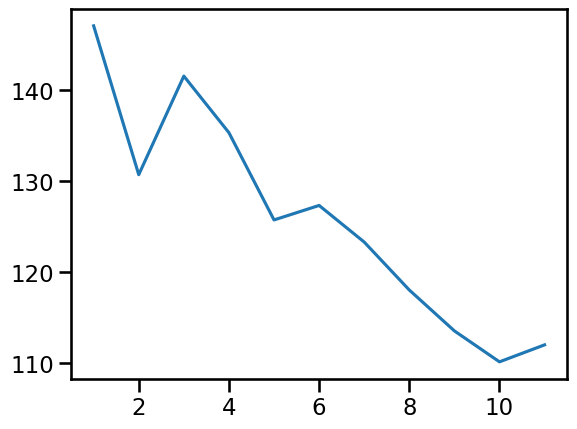

In [220]:
## train KNN
val_maes = []
val_mses = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_mae = mean_absolute_error(val_dataset[:][1], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(val_dataset[:][1], preds)
    val_mses.append(val_mse)
plt.plot(Ks, val_mses)

In [221]:
bestk = Ks[np.argmin(val_mses)]
print("best K = ", bestk)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = KNeighborsRegressor(n_neighbors=bestk)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test MAE: ", mean_absolute_error(test_dataset[:][1], preds))
print("test MSE: ", mean_squared_error(test_dataset[:][1], preds))

best K =  10
val MAE:  8.450000000000003
val MSE:  110.15294117647059
test MAE:  10.155882352941175
test MSE:  187.64794117647057


### linear regression 

In [222]:
val_maes = []
val_mses = []

neigh = LinearRegression()
neigh.fit(train_dataset[:][0], train_dataset[:][1])

preds = neigh.predict(val_dataset[:][0])
print("val MAE: ", mean_absolute_error(val_dataset[:][1], preds))
print("val MSE: ", mean_squared_error(val_dataset[:][1], preds))

preds = neigh.predict(test_dataset[:][0])
print("test MAE: ", mean_absolute_error(test_dataset[:][1], preds))
print("test MSE: ", mean_squared_error(test_dataset[:][1], preds))

val MAE:  8.933824
val MSE:  132.8985
test MAE:  11.692555
test MSE:  261.1502


### lasso

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.355e+03, tolerance: 4.474e+00
  model = cd_fast.enet_coordinate_descent(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.686e+03, tolerance: 4.474e+00
  model = cd_fast.enet_coordinate_descent(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

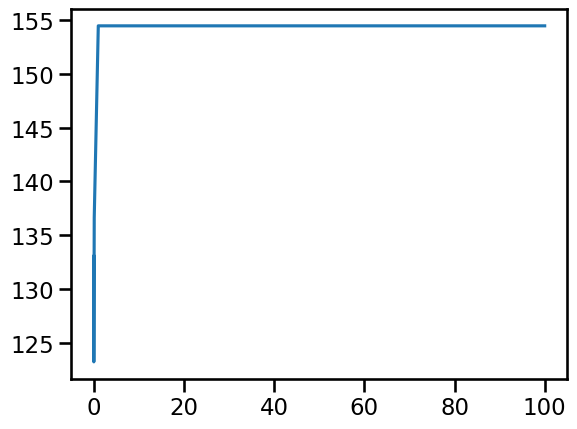

In [223]:
val_maes = []
val_mses = []
alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
for alpha in alphas:
    neigh = Lasso(alpha=alpha)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_mae = mean_absolute_error(val_dataset[:][1], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(val_dataset[:][1], preds)
    val_mses.append(val_mse)
plt.plot(alphas, val_mses)

In [224]:
bestalpha = alphas[np.argmin(val_mses)]
print("best alpha = ", bestalpha)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = Lasso(alpha=bestalpha)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test MAE: ", mean_absolute_error(test_dataset[:][1], preds))
print("test MSE: ", mean_squared_error(test_dataset[:][1], preds))

best alpha =  0.01
val MAE:  8.738497608764266
val MSE:  123.24988572406586
test MAE:  9.571252973330322
test MSE:  159.13224210920615


### random forest

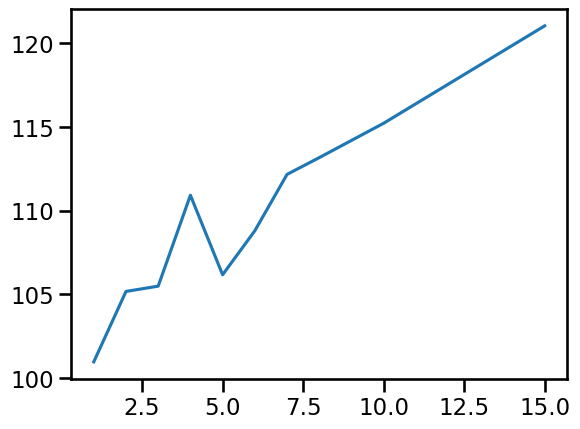

In [229]:
val_maes = []
val_mses = []
Cs = [1,2,3,4,5,6,7,8,10,15]
for c in Cs:
    neigh = RandomForestRegressor(min_samples_leaf=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_mae = mean_absolute_error(val_dataset[:][1], preds)
    val_maes.append(val_mae)
    val_mse = mean_squared_error(val_dataset[:][1], preds)
    val_mses.append(val_mse)

plt.plot(Cs, val_mses)

In [230]:
bestc = Cs[np.argmin(val_mses)]
print("best min_samples_leaf = ", bestc)
print("val MAE: ", val_maes[np.argmin(val_mses)])
print("val MSE: ", val_mses[np.argmin(val_mses)])

neigh = RandomForestRegressor(min_samples_leaf=bestc)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test MAE: ", mean_absolute_error(test_dataset[:][1], preds))
print("test MSE: ", mean_squared_error(test_dataset[:][1], preds))

best min_samples_leaf =  1
val MAE:  8.120294117647058
val MSE:  100.98044999999998
test MAE:  9.364558823529412
test MSE:  153.31973088235299


# predict biopsy site: primary vs metastatic, based on tumor cells alone

In [123]:
sample_col = 'sample'
target_col = 'origin'


In [124]:
luca_adata.obs[[sample_col, target_col]].drop_duplicates()[target_col].value_counts()

tumor_primary       254
normal_adjacent     137
normal              109
tumor_metastasis     54
nan                   2
Name: origin, dtype: int64

In [125]:
## why do normal samples have tumor cells???
#summarize by study - showcasing that many normal samples have cells labeled as malignant
luca_malig_filter = pd.DataFrame(luca_adata.obs.groupby(["disease","study", "origin"]).cell_type.value_counts()).rename(columns={'cell_type':'cell_type_counts'})
luca_malig_filter = luca_malig_filter.reset_index()
luca_malig_filter[((luca_malig_filter.origin!="tumor_primary") & (luca_malig_filter.origin!="tumor_metastasis")) & (luca_malig_filter.cell_type=="malignant cell") & (luca_malig_filter.cell_type_counts !=0)].sort_values("cell_type_counts", ascending=False)
#184 samples total

disease                      study  \
1557                                 normal    Travaglini_Krasnow_2020   
553                     lung adenocarcinoma          Leader_Merad_2021   
1528                                 normal      Reyfman_Misharin_2018   
709                     lung adenocarcinoma                     UKIM-V   
1405                                 normal        Adams_Kaminski_2020   
1474                                 normal       Madissoon_Meyer_2020   
26    chronic obstructive pulmonary disease        Adams_Kaminski_2020   
1441                                 normal     Habermann_Kropski_2020   
1497                                 normal         Mayr_Schiller_2020   
1593                                 normal      Vieira_Teichmann_2019   
1046           squamous cell lung carcinoma          Leader_Merad_2021   
380                     lung adenocarcinoma  Lambrechts_Thienpont_2018   
1138           squamous cell lung carcinoma                     UKIM-V   
192                     lung adenocarcinoma                He_Fan_2021   
1305          non-small cell lung carcinoma  Lambrechts_Thienpont_2018   
292                     lung adenocarcinoma               Kim_Lee_2020   
55                      lung adenocarcinoma      Goveia_Carmeliet_2020   
847            squamous cell lung carcinoma      Goveia_Carmeliet_2020   
618                     lung adenocarcinoma        Maynard_Bivona_2020   
981            squamous cell lung carcinoma  Lambrechts_Thienpont_2018   
457                     lung adenocarcinoma     Laughney_Massague_2020   
252                     lung adenocarcinoma               Kim_Lee_2020   

               origin       cell_type  cell_type_counts  
1557  normal_adjacent  malignant cell               449  
553   normal_adjacent  malignant cell               228  
1528           normal  malignant cell               210  
709   normal_adjacent  malignant cell               204  
1405           normal  malignant cell               192  
1474           normal  malignant cell               166  
26             normal  malignant cell               142  
1441           normal  malignant cell               135  
1497  normal_adjacent  malignant cell               122  
1593  normal_adjacent  malignant cell                99  
1046  normal_adjacent  malignant cell                87  
380   normal_adjacent  malignant cell                67  
1138  normal_adjacent  malignant cell                62  
192   normal_adjacent  malignant cell                51  
1305  normal_adjacent  malignant cell                31  
292   normal_adjacent  malignant cell                22  
55    normal_adjacent  malignant cell                 5  
847   normal_adjacent  malignant cell                 3  
618               nan  malignant cell                 3  
981   normal_adjacent  malignant cell                 3  
457   normal_adjacent  malignant cell                 2  
252            normal  malignant cell                 2

(array([18., 15., 12.,  8.,  7.,  7.,  6.,  2.,  2.,  2., 10.,  5.,  4.,
         2.,  7.,  1.,  3.,  5.,  4.,  3.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ,
        54.9, 59.8, 64.7, 69.6, 74.5, 79.4, 84.3, 89.2, 94.1, 99. ]),
 <BarContainer object of 20 artists>)

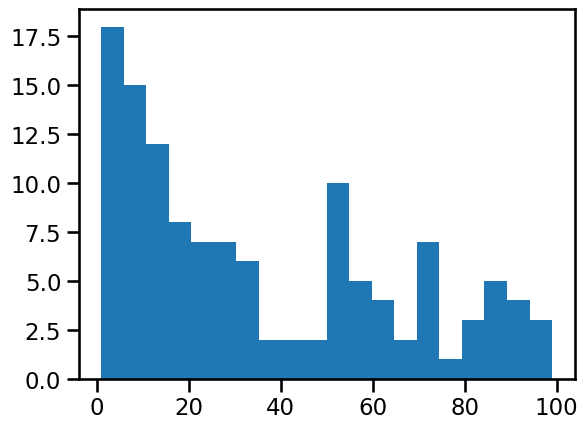

In [126]:
#only keep samples that have >=n tumor cells. histogram of n tumor cells per sample, for samples with 0 > n < 100 cells. To help decide on cutoff
luca_malig_filter = pd.DataFrame(luca_adata.obs.groupby(["origin",sample_col]).cell_type.value_counts()).rename(columns={'cell_type':'cell_type_counts'})
luca_malig_filter = luca_malig_filter.reset_index()
luca_malig_filter = luca_malig_filter[((luca_malig_filter.origin=="tumor_primary") | (luca_malig_filter.origin=="tumor_metastasis")) & (luca_malig_filter.cell_type=="malignant cell") & (luca_malig_filter.cell_type_counts !=0)]

plt.hist(luca_malig_filter[luca_malig_filter.cell_type_counts<=100].cell_type_counts, bins=20)

In [127]:
luca_malig_filter.index = luca_malig_filter['sample']

tumor_cell_samples = luca_malig_filter[luca_malig_filter.cell_type_counts >=15]['sample']

In [128]:
len(tumor_cell_samples)

206

In [129]:
#get sample IDs that are not NA for this target
notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col]!="nan"]
print("this target has {} non-NA samples".format(len(notNA_samples)))

this target has 554 non-NA samples


In [130]:
sample_pool = np.intersect1d(tumor_cell_samples, notNA_samples)

In [131]:
## Define targets
targets = luca_adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [132]:
labels

array(['tumor_metastasis', 'tumor_primary'], dtype=object)

In [133]:
targets.value_counts()/len(targets)

1    0.825243
0    0.174757
dtype: float64

In [139]:
#70/15/15 split
from sklearn.model_selection import train_test_split
trainvalsamples, test_samples= train_test_split(sample_pool, test_size=0.15, random_state=18, stratify=targets)
train_samples, val_samples = train_test_split(trainvalsamples, test_size=0.15/0.85, random_state=18, stratify=targets[trainvalsamples])
del trainvalsamples

In [140]:
print(len(train_samples))
print(len(val_samples))
print(len(test_samples))


144
31
31


## create dataloader and train on scANVI embeddings

In [141]:
bsize = 32 
emb_name = 'X_scANVI'
input_size = luca_adata.obsm[emb_name].shape[1]

#get sample IDs that are not NA for this target
#notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
#print("this target has {} non-NA samples".format(len(notNA_samples)))

## Input
# in this case, limiting pseudobulk input to only contain tumor cells
pseudobulk_input = pd.DataFrame(luca_adata.obsm[emb_name][luca_adata.obs.cell_type=="malignant cell",:], index=luca_adata.obs.loc[luca_adata.obs.cell_type=="malignant cell",sample_col]).reset_index().groupby(sample_col).mean()

## Create train, val, test datasets
train_input = pseudobulk_input.loc[train_samples,:].dropna()
val_input = pseudobulk_input.loc[val_samples,:].dropna()
test_input = pseudobulk_input.loc[test_samples,:].dropna()

train_targets = torch.tensor(targets.loc[train_samples], dtype=torch.uint8)
val_targets = torch.tensor(targets.loc[val_samples], dtype=torch.uint8)
test_targets = torch.tensor(targets.loc[test_samples], dtype=torch.uint8)

train_dataset = TensorDataset(torch.Tensor(np.array(train_input)), train_targets)
val_dataset = TensorDataset(torch.Tensor(np.array(val_input)), val_targets)
test_dataset = TensorDataset(torch.Tensor(np.array(test_input)), test_targets)

## Create DataLoader for each split
#train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=True)

In [142]:
pd.Series(train_targets).value_counts()

1    118
0     26
dtype: int64

In [143]:
pd.Series(val_targets).value_counts()

1    26
0     5
dtype: int64

In [144]:
pd.Series(test_targets).value_counts()

1    26
0     5
dtype: int64

### majority class

In [145]:
pd.Series(val_targets).value_counts()/len(val_targets)

1    0.83871
0    0.16129
dtype: float64

In [146]:
pd.Series(test_targets).value_counts()/len(test_targets)

1    0.83871
0    0.16129
dtype: float64

### KNN

In [147]:
## train KNN
val_accs = []
Ks = [2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    print("nneighbors ", k)
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    print("val acc ", val_acc)
    print("val AUC ", roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    print("\n")

nneighbors  2
val acc  0.7741935483870968
val AUC  0.6153846153846154


nneighbors  3
val acc  0.8064516129032258
val AUC  0.6153846153846154


nneighbors  4
val acc  0.8387096774193549
val AUC  0.6346153846153846


nneighbors  5
val acc  0.8387096774193549
val AUC  0.6846153846153846


nneighbors  6
val acc  0.8709677419354839
val AUC  0.6538461538461539


nneighbors  7
val acc  0.8387096774193549
val AUC  0.6346153846153846


nneighbors  8
val acc  0.8387096774193549
val AUC  0.6961538461538461


nneighbors  9
val acc  0.8387096774193549
val AUC  0.726923076923077


nneighbors  10
val acc  0.8387096774193549
val AUC  0.7076923076923076


nneighbors  11
val acc  0.8387096774193549
val AUC  0.7115384615384615




In [148]:
bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best K =  6
test acc:  0.8064516129032258
test AUC  0.6153846153846154


### logistic regression 

In [149]:
## train KNN
val_accs = []
Cs = [1e-3, 1e-2, 1e-1, 1, 10, 100]
for c in Cs:
    print("C ", c)
    neigh = LogisticRegression(C=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    print("val acc ", val_acc)
    print("val AUC ", roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    print("\n")

C  0.001
val acc  0.8387096774193549
val AUC  0.5153846153846153


C  0.01
val acc  0.8387096774193549
val AUC  0.5153846153846153


C  0.1
val acc  0.8387096774193549
val AUC  0.5230769230769231


C  1
val acc  0.8387096774193549
val AUC  0.5307692307692309


C  10
val acc  0.8387096774193549
val AUC  0.5538461538461539


C  100
val acc  0.8387096774193549
val AUC  0.5615384615384615




In [150]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
neigh = LogisticRegression(C=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  0.001
test acc:  0.8064516129032258
test AUC  0.46153846153846156


### random forest

In [151]:
val_accs = []
Cs = [1]
for c in Cs:
    print("C ", c)
    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    print("val acc ", val_acc)
    print("val AUC ", roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    print("\n")

C  1
val acc  0.8387096774193549
val AUC  0.6961538461538461




In [152]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
neigh = RandomForestClassifier(min_samples_leaf=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  1
test acc:  0.8387096774193549
test AUC  0.676923076923077


## create dataloader and train on scGPT embeddings

In [153]:
#bsize = 32 
emb_name = 'X_scGPT'
input_size = luca_adata.obsm[emb_name].shape[1]

#get sample IDs that are not NA for this target
#notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
#print("this target has {} non-NA samples".format(len(notNA_samples)))

## Input
# in this case, limiting pseudobulk input to only contain tumor cells
pseudobulk_input = pd.DataFrame(luca_adata.obsm[emb_name][luca_adata.obs.cell_type=="malignant cell",:], index=luca_adata.obs.loc[luca_adata.obs.cell_type=="malignant cell",sample_col]).reset_index().groupby(sample_col).mean()

## Create train, val, test datasets
train_input = pseudobulk_input.loc[train_samples,:].dropna()
val_input = pseudobulk_input.loc[val_samples,:].dropna()
test_input = pseudobulk_input.loc[test_samples,:].dropna()

train_targets = torch.tensor(targets.loc[train_samples], dtype=torch.uint8)
val_targets = torch.tensor(targets.loc[val_samples], dtype=torch.uint8)
test_targets = torch.tensor(targets.loc[test_samples], dtype=torch.uint8)

train_dataset = TensorDataset(torch.Tensor(np.array(train_input)), train_targets)
val_dataset = TensorDataset(torch.Tensor(np.array(val_input)), val_targets)
test_dataset = TensorDataset(torch.Tensor(np.array(test_input)), test_targets)

## Create DataLoader for each split
#train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=True)

### KNN

In [154]:
val_accs = []
Ks = [2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    print("nneighbors ", k)
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    print("val acc ", val_acc)
    print("val AUC ", roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    print("\n")

nneighbors  2
val acc  0.8387096774193549
val AUC  0.7307692307692308


nneighbors  3
val acc  0.8387096774193549
val AUC  0.8038461538461539


nneighbors  4
val acc  0.8387096774193549
val AUC  0.8038461538461539


nneighbors  5
val acc  0.7741935483870968
val AUC  0.7461538461538462


nneighbors  6
val acc  0.7741935483870968
val AUC  0.7692307692307692


nneighbors  7
val acc  0.7741935483870968
val AUC  0.8384615384615386


nneighbors  8
val acc  0.7741935483870968
val AUC  0.8230769230769232


nneighbors  9
val acc  0.7741935483870968
val AUC  0.7692307692307693


nneighbors  10
val acc  0.7741935483870968
val AUC  0.7961538461538462


nneighbors  11
val acc  0.8387096774193549
val AUC  0.8038461538461539




In [155]:
bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best K =  2
test acc:  0.6774193548387096
test AUC  0.65


### LR

In [156]:
val_accs = []
Cs = [1e-3, 1e-2, 1e-1, 1, 10, 100]
for c in Cs:
    print("C ", c)
    neigh = LogisticRegression(C=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    print("val acc ", val_acc)
    print("val AUC ", roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    print("\n")

C  0.001
val acc  0.8387096774193549
val AUC  0.8


C  0.01
val acc  0.8387096774193549
val AUC  0.8


C  0.1
val acc  0.8387096774193549
val AUC  0.8


C  1
val acc  0.8387096774193549
val AUC  0.8307692307692308


C  10
val acc  0.8387096774193549
val AUC  0.8461538461538461


C  100
val acc  0.8387096774193549
val AUC  0.8846153846153847




In [157]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
neigh = LogisticRegression(C=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  0.001
test acc:  0.8709677419354839
test AUC  0.7769230769230769


### train random forest

In [158]:
val_accs = []
Cs = [1]
for c in Cs:
    print("C ", c)
    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    print("val acc ", val_acc)
    print("val AUC ", roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    print("\n")

C  1
val acc  0.8387096774193549
val AUC  0.9000000000000001




In [159]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
neigh = RandomForestClassifier(min_samples_leaf=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  1
test acc:  0.8387096774193549
test AUC  0.8615384615384616


# predict stage: early vs advanced - only include lung biopsies (pretty hard problem), all cells

In [7]:
sample_col = 'sample'
target_col = 'tumor_stage'

#get sample IDs that are not NA for this target
notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
print("this target has {} non-NA samples".format(len(notNA_samples)))


this target has 555 non-NA samples


In [8]:
# dont include non-cancer samples
cancer_samples = luca_adata.obs.loc[luca_adata.obs.tumor_stage!="non-cancer",sample_col].drop_duplicates()

In [9]:
# only include lung samples
lung_samples = luca_adata.obs.loc[luca_adata.obs.tissue=="lung",sample_col].drop_duplicates()

In [10]:
sample_pool = np.intersect1d(np.intersect1d(cancer_samples, notNA_samples), lung_samples)
print(len(sample_pool))

376


In [11]:
## Define targets
targets = luca_adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [12]:
labels

array(['advanced', 'early'], dtype=object)

In [13]:
targets.value_counts()/len(targets)

1    0.662234
0    0.337766
Name: count, dtype: float64

## create splits  

### split samples, stratify splits by outcome. don't separate datasets into different splits

In [105]:
#70/15/15 split
from sklearn.model_selection import train_test_split
trainvalsamples, test_samples= train_test_split(sample_pool, test_size=0.15, random_state=18, stratify=targets)
train_samples, val_samples = train_test_split(trainvalsamples, test_size=0.15/0.85, random_state=18, stratify=targets[trainvalsamples])
del trainvalsamples

### splits for leave one (dataset) out cross validation

In [14]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=10)
groups = luca_adata.obs.set_index('sample').loc[sample_pool, 'dataset'].reset_index().drop_duplicates().dataset
splits = list(group_kfold.split(sample_pool, groups=groups)) #if don't convert to list, iterator is exhausted after one use


In [19]:
for (train_index, test_index) in splits:
    print("datasets reserved for test fold: ", list(luca_adata.obs.set_index('sample').loc[sample_pool[test_index]].dataset.drop_duplicates()))
    print("n samples in train: ", len(train_index))
    print("n samples in test: ", len(test_index))
    print("\n")

datasets reserved for test fold:  ['Guo_Zhang_2018']
n samples in train:  313
n samples in test:  63


datasets reserved for test fold:  ['Wu_Zhou_2021']
n samples in train:  334
n samples in test:  42


datasets reserved for test fold:  ['Leader_Merad_2021_10x_3p_v2_beads']
n samples in train:  338
n samples in test:  38


datasets reserved for test fold:  ['Lambrechts_Thienpont_2018_6149v1', 'UKIM-V-2']
n samples in train:  341
n samples in test:  35


datasets reserved for test fold:  ['Kim_Lee_2020', 'Leader_Merad_2021_10x_3p_v2_sort']
n samples in train:  342
n samples in test:  34


datasets reserved for test fold:  ['He_Fan_2021', 'Leader_Merad_2021_10x_3p_v2_digest-deadcell_cite']
n samples in train:  344
n samples in test:  32


datasets reserved for test fold:  ['Lambrechts_Thienpont_2018_6149v2', 'Leader_Merad_2021_10x_5p_v1_beads', 'Leader_Merad_2021_10x_3p_v2_beads_cite']
n samples in train:  344
n samples in test:  32


datasets reserved for test fold:  ['Chen_Zhang_2020'

## create dataloader and train on scANVI embeddings

In [491]:
emb_name = 'X_scANVI'
input_size = luca_adata.obsm[emb_name].shape[1]

#get sample IDs that are not NA for this target
#notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
#print("this target has {} non-NA samples".format(len(notNA_samples)))

## Input
pseudobulk_input = pd.DataFrame(luca_adata.obsm[emb_name], index=luca_adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()
pseudobulk_input = pseudobulk_input.loc[sample_pool]

In [ ]:
## this is for original splitting scheme (stratified split, not separated by dataset)
## Create train, val, test datasets
train_input = pseudobulk_input.loc[train_samples,:].dropna()
val_input = pseudobulk_input.loc[val_samples,:].dropna()
test_input = pseudobulk_input.loc[test_samples,:].dropna()

train_targets = torch.tensor(targets.loc[train_samples], dtype=torch.uint8)
val_targets = torch.tensor(targets.loc[val_samples], dtype=torch.uint8)
test_targets = torch.tensor(targets.loc[test_samples], dtype=torch.uint8)

train_dataset = TensorDataset(torch.Tensor(np.array(train_input)), train_targets)
val_dataset = TensorDataset(torch.Tensor(np.array(val_input)), val_targets)
test_dataset = TensorDataset(torch.Tensor(np.array(test_input)), test_targets)

## Create DataLoader for each split
#train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=True)

In [59]:
pd.Series(train_targets).value_counts()

1    173
0     89
dtype: int64

In [60]:
pd.Series(val_targets).value_counts()

1    38
0    19
dtype: int64

In [61]:
pd.Series(test_targets).value_counts()

1    38
0    19
dtype: int64

### majority class

In [312]:
pd.Series(val_targets).value_counts()/len(val_targets)

1    0.666667
0    0.333333
dtype: float64

In [313]:
pd.Series(test_targets).value_counts()/len(test_targets)

1    0.666667
0    0.333333
dtype: float64

In [327]:
print("validate 95% CI: ", accuracy_confidence_interval(0.6667, len(val_dataset)))
print("test 95% CI: ", accuracy_confidence_interval(0.6667, len(test_dataset)))

validate 95% CI:  (0.54, 0.67, 0.79)
test 95% CI:  (0.54, 0.67, 0.79)


### majority class by dataset

In [388]:
dataset_stage_n = luca_adata.obs[['sample','dataset',target_col]].drop_duplicates().set_index('sample').loc[train_samples,['dataset',target_col]].groupby('dataset',observed=True).value_counts().reset_index()#
majority_rows = dataset_stage_n.groupby('dataset',observed=True)[0].idxmax()

In [ ]:
majority_preds = dataset_stage_n.iloc[majority_rows,:].rename(columns={'tumor_stage':'predicted tumor stage'}).drop(columns=[0])


In [398]:
val_preds = luca_adata.obs[['sample','dataset',target_col]].drop_duplicates().set_index('sample').loc[val_samples,['dataset',target_col]].merge(majority_preds, how="left")

In [400]:
(val_preds.tumor_stage == val_preds['predicted tumor stage']).sum()/len(val_preds)

0.7192982456140351

In [403]:
test_preds = luca_adata.obs[['sample','dataset',target_col]].drop_duplicates().set_index('sample').loc[test_samples,['dataset',target_col]].merge(majority_preds, how="left")

In [404]:
(test_preds.tumor_stage == test_preds['predicted tumor stage']).sum()/len(test_preds)

0.8245614035087719

In [405]:
print("validate 95% CI: ", accuracy_confidence_interval(0.719, len(val_dataset)))
print("test 95% CI: ", accuracy_confidence_interval(0.82456, len(test_dataset)))

validate 95% CI:  (0.6, 0.72, 0.84)
test 95% CI:  (0.73, 0.82, 0.92)


### KNN

In [563]:
## train KNN w/ Kfold CV
val_accs = []
test_accs= []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
chosen_ks = []
val_majclass_bline_accs = []
test_majclass_bline_accs = []
#k=9
for (train_index, test_index) in splits:

    val_accs_hparam_search = []

    #split test set into val and test halves
    val_index = test_index[:int(len(test_index)/2)]
    test_index = test_index[int(len(test_index)/2):]

    #calculate baseline performance - majority class
    majclass_bline_pred = targets[train_index].value_counts().index[targets[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets[val_index].value_counts()[majclass_bline_pred]/len(val_index))
    if majclass_bline_pred not in targets[test_index].value_counts().index:
        test_majclass_bline_accs.append(0)
    else:
        test_majclass_bline_accs.append(targets[test_index].value_counts()[majclass_bline_pred]/len(test_index))

    for k in Ks:
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets[train_index])
        preds = neigh.predict(pseudobulk_input.iloc[targets[val_index],:].dropna())
        val_acc = accuracy_score(targets[val_index], preds)
        val_accs_hparam_search.append(val_acc)

    bestk = Ks[np.argmax(val_accs_hparam_search)]
    chosen_ks.append(bestk)

    neigh = KNeighborsClassifier(n_neighbors=bestk)
    neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets[train_index])

    #final val score
    preds = neigh.predict(pseudobulk_input.iloc[targets[val_index],:].dropna())
    val_acc = accuracy_score(targets[val_index], preds)
    val_accs.append(val_acc)

    #final test score
    preds = neigh.predict(pseudobulk_input.iloc[targets[test_index],:].dropna())
    test_acc = accuracy_score(targets[test_index], preds)
    test_accs.append(test_acc)

    #avoid error in roc_auc when only one class is present
    #val_auc = roc_auc_score(targets[test_index], neigh.predict_proba(pseudobulk_input.iloc[targets[test_index],:].dropna())[:,1])
    #val_aucs.append(val_auc)
    #plt.plot(Ks, val_accs)

In [576]:
print("mean val acc across folds: ", np.round(np.mean(val_accs),3))
print("mean majority class baseline val acc across folds: ", np.round(np.mean(val_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(val_accs, val_majclass_bline_accs)[1],3)))
print("\n")
print("mean test acc across folds: ", np.round(np.mean(test_accs),3))
print("mean majority class baseline test acc across folds: ", np.round(np.mean(test_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(test_accs, test_majclass_bline_accs)[1],3)))


mean val acc across folds:  0.732
mean majority class baseline val acc across folds:  0.679
wilcoxon signed-rank test p-value=0.465


mean test acc across folds:  0.758
mean majority class baseline test acc across folds:  0.646
wilcoxon signed-rank test p-value=0.465


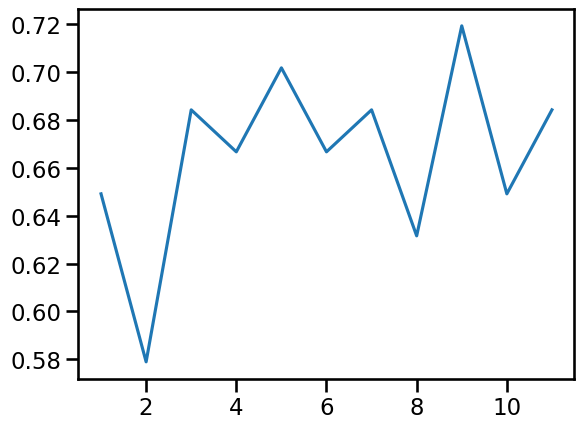

In [62]:
## train KNN
val_accs = []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1])
    #roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    val_aucs.append(val_auc)
plt.plot(Ks, val_accs)

In [63]:
bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC: ", val_aucs[np.argmax(val_accs)])

neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC: ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best K =  9
val acc:  0.7192982456140351
val AUC:  0.6682825484764543
test acc:  0.7894736842105263
test AUC:  0.8386426592797785


### logistic regression 

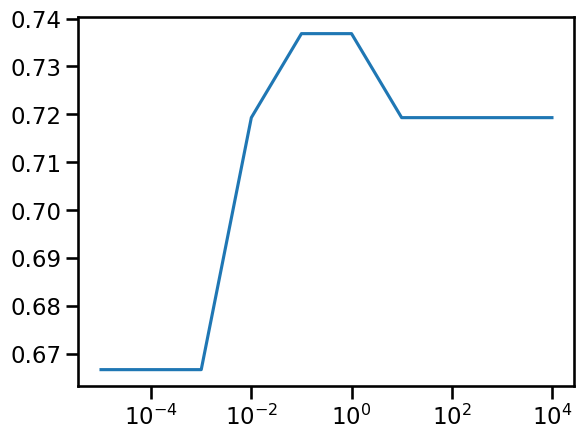

In [347]:
val_accs = []
val_aucs = []
Cs = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]
for c in Cs:
    neigh = LogisticRegression(C=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
plt.plot(Cs, val_accs)
plt.xscale("log")

In [349]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC ", val_aucs[np.argmax(val_accs)])
neigh = LogisticRegression(C=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  0.1
val acc:  0.7368421052631579
val AUC  0.6537396121883656
test acc:  0.7192982456140351
test AUC  0.6939058171745152


### random forest

In [ ]:
val_accs = []
val_aucs = []
Cs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for c in Cs:
    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))

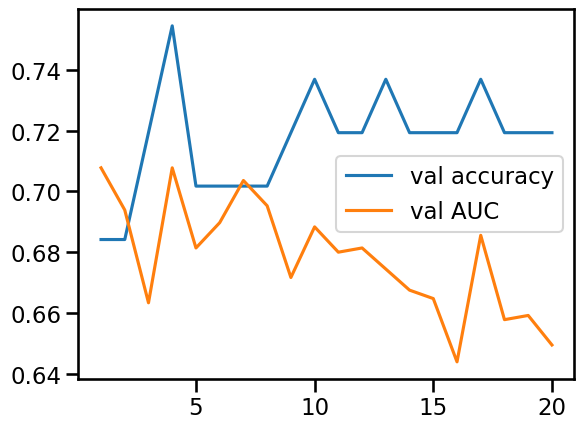

In [361]:
plt.plot(Cs, val_accs, label="val accuracy")
plt.plot(Cs, val_aucs, label="val AUC")
plt.legend()

In [362]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("test acc: ", val_accs[np.argmax(val_accs)])
print("test AUC ", val_aucs[np.argmax(val_accs)])

neigh = RandomForestClassifier(min_samples_leaf=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  4
test acc:  0.7543859649122807
test AUC  0.7077562326869806
test acc:  0.7368421052631579
test AUC  0.7146814404432132


## create dataloader and train on scGPT embeddings

In [20]:
emb_name = 'X_scGPT'
input_size = luca_adata.obsm[emb_name].shape[1]

#get sample IDs that are not NA for this target
#notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
#print("this target has {} non-NA samples".format(len(notNA_samples)))

## Input
pseudobulk_input = pd.DataFrame(luca_adata.obsm[emb_name], index=luca_adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pseudobulk_input = pseudobulk_input.loc[sample_pool,:]

#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#pseudobulk_input_scaled = scaler.fit_transform(pseudobulk_input)
#pseudobulk_input = pd.DataFrame(pseudobulk_input_scaled, index = pseudobulk_input.index, columns = pseudobulk_input.columns)

/tmp/ipykernel_1679613/316364811.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(luca_adata.obsm[emb_name], index=luca_adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


### KNN

In [25]:
## train KNN w/ Kfold CV
val_accs = []
test_accs= []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
chosen_ks = []
val_majclass_bline_accs = []
test_majclass_bline_accs = []
#k=9
for (train_index, test_index) in splits:

    val_accs_hparam_search = []

    #split test set into val and test halves
    val_index = test_index[:int(len(test_index)/2)]
    test_index = test_index[int(len(test_index)/2):]

    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))
    if majclass_bline_pred not in targets.iloc[test_index].value_counts().index:
        test_majclass_bline_accs.append(0)
    else:
        test_majclass_bline_accs.append(targets.iloc[test_index].value_counts()[majclass_bline_pred]/len(test_index))

    for k in Ks:
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets.iloc[train_index])
        preds = neigh.predict(pseudobulk_input.iloc[val_index,:].dropna())
        val_acc = accuracy_score(targets.iloc[val_index], preds)
        val_accs_hparam_search.append(val_acc)

    bestk = Ks[np.argmax(val_accs_hparam_search)]
    chosen_ks.append(bestk)

    neigh = KNeighborsClassifier(n_neighbors=bestk)
    neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets.iloc[train_index])

    #final val score
    preds = neigh.predict(pseudobulk_input.iloc[val_index,:].dropna())
    val_acc = accuracy_score(targets.iloc[val_index], preds)
    val_accs.append(val_acc)

    #final test score
    preds = neigh.predict(pseudobulk_input.iloc[test_index,:].dropna())
    test_acc = accuracy_score(targets.iloc[test_index], preds)
    test_accs.append(test_acc)

    #avoid error in roc_auc when only one class is present
    #val_auc = roc_auc_score(targets.iloc[test_index], neigh.predict_proba(pseudobulk_input.iloc[targets[test_index],:].dropna())[:,1])
    #val_aucs.append(val_auc)
    #plt.plot(Ks, val_accs)

In [26]:
print("mean val acc across folds: ", np.round(np.mean(val_accs),3))
print("mean majority class baseline val acc across folds: ", np.round(np.mean(val_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(val_accs, val_majclass_bline_accs)[1],3)))
print("\n")
print("mean test acc across folds: ", np.round(np.mean(test_accs),3))
print("mean majority class baseline test acc across folds: ", np.round(np.mean(test_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(test_accs, test_majclass_bline_accs)[1],3)))


mean val acc across folds:  0.661
mean majority class baseline val acc across folds:  0.637
wilcoxon signed-rank test p-value=0.686


mean test acc across folds:  0.649
mean majority class baseline test acc across folds:  0.721
wilcoxon signed-rank test p-value=0.109


In [21]:
## train KNN w/ Kfold CV
val_accs = []
test_accs= []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
chosen_ks = []
val_majclass_bline_accs = []
test_majclass_bline_accs = []
#k=9
for (train_index, test_index) in splits:

    val_accs_hparam_search = []

    #split test set into val and test halves
    val_index = test_index[:int(len(test_index)/2)]
    test_index = test_index[int(len(test_index)/2):]

    #calculate baseline performance - majority class
    majclass_bline_pred = targets[train_index].value_counts().index[targets[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets[val_index].value_counts()[majclass_bline_pred]/len(val_index))
    if majclass_bline_pred not in targets[test_index].value_counts().index:
        test_majclass_bline_accs.append(0)
    else:
        test_majclass_bline_accs.append(targets[test_index].value_counts()[majclass_bline_pred]/len(test_index))

    for k in Ks:
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets[train_index])
        preds = neigh.predict(pseudobulk_input.iloc[targets[val_index],:].dropna())
        val_acc = accuracy_score(targets[val_index], preds)
        val_accs_hparam_search.append(val_acc)

    bestk = Ks[np.argmax(val_accs_hparam_search)]
    chosen_ks.append(bestk)

    neigh = KNeighborsClassifier(n_neighbors=bestk)
    neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets[train_index])

    #final val score
    preds = neigh.predict(pseudobulk_input.iloc[targets[val_index],:].dropna())
    val_acc = accuracy_score(targets[val_index], preds)
    val_accs.append(val_acc)

    #final test score
    preds = neigh.predict(pseudobulk_input.iloc[targets[test_index],:].dropna())
    test_acc = accuracy_score(targets[test_index], preds)
    test_accs.append(test_acc)

    #avoid error in roc_auc when only one class is present
    #val_auc = roc_auc_score(targets[test_index], neigh.predict_proba(pseudobulk_input.iloc[targets[test_index],:].dropna())[:,1])
    #val_aucs.append(val_auc)
    #plt.plot(Ks, val_accs)

/tmp/ipykernel_1679613/19940047.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  majclass_bline_pred = targets[train_index].value_counts().index[targets[train_index].value_counts().argmax()]
/tmp/ipykernel_1679613/19940047.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if majclass_bline_pred not in targets[val_index].value_counts().index:
/tmp/ipykernel_1679613/19940047.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  

In [600]:
print("mean val acc across folds: ", np.round(np.mean(val_accs),3))
print("mean majority class baseline val acc across folds: ", np.round(np.mean(val_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(val_accs, val_majclass_bline_accs)[1],3)))
print("\n")
print("mean test acc across folds: ", np.round(np.mean(test_accs),3))
print("mean majority class baseline test acc across folds: ", np.round(np.mean(test_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(test_accs, test_majclass_bline_accs)[1],3)))


mean val acc across folds:  0.945
mean majority class baseline val acc across folds:  0.637
wilcoxon signed-rank test p-value=0.012


mean test acc across folds:  0.984
mean majority class baseline test acc across folds:  0.721
wilcoxon signed-rank test p-value=0.027


/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


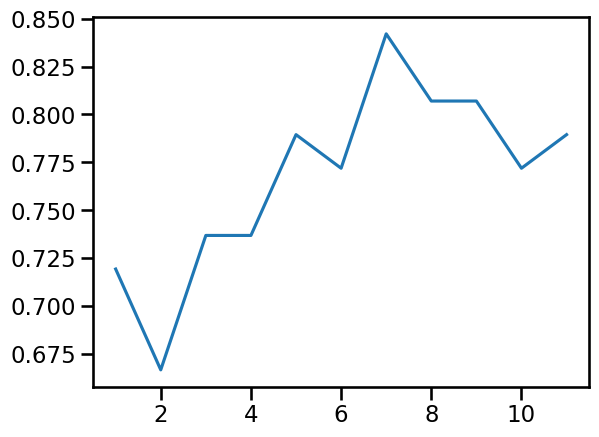

In [308]:
## train KNN
val_accs = []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1])
    #roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    val_aucs.append(val_auc)
plt.plot(Ks, val_accs)

In [318]:
bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC: ", val_aucs[np.argmax(val_accs)])

neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
test_acc = accuracy_score(test_dataset[:][1], preds)
print("test acc: ", test_acc)
print("test AUC: ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best K =  7
val acc:  0.8421052631578947
val AUC:  0.82202216066482
test acc:  0.7894736842105263
test AUC:  0.8656509695290858


In [323]:
print("val (lower, mean, upper) 95% CI")
print(accuracy_confidence_interval(val_accs[np.argmax(val_accs)], len(val_dataset)))

val (lower, mean, upper) 95% CI
(0.7474428261319732, 0.8421052631578947, 0.9367677001838162)


In [324]:
print("test (lower, mean, upper) 95% CI")
print(accuracy_confidence_interval(test_acc, len(test_dataset)))

test (lower, mean, upper) 95% CI
(0.6836378621576497, 0.7894736842105263, 0.895309506263403)


### logistic regression 

#### for non groupkfold splits

In [ ]:
val_accs = []
val_aucs = []
Cs = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]
for c in Cs:
    neigh = LogisticRegression(C=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
plt.plot(Cs, val_accs)
plt.xscale("log")

In [377]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC ", val_aucs[np.argmax(val_accs)])
neigh = LogisticRegression(C=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  100
val acc:  0.8421052631578947
val AUC  0.8185595567867037
test acc:  0.7543859649122807
test AUC  0.7506925207756232


/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### for groupkfold splits

In [98]:
print("train class balanace\n", targets.iloc[train_index].value_counts())
targets.iloc[train_index]

train class balanace
 1    228
0    114
Name: count, dtype: int64


sample
Chen_Zhang_2020_NSCLC-1     1
Chen_Zhang_2020_NSCLC-10    0
Chen_Zhang_2020_NSCLC-11    1
Chen_Zhang_2020_NSCLC-2     1
Chen_Zhang_2020_NSCLC-3     1
                           ..
Zilionis_Klein_2019_p5t2    0
Zilionis_Klein_2019_p6t1    1
Zilionis_Klein_2019_p6t2    1
Zilionis_Klein_2019_p7t1    0
Zilionis_Klein_2019_p7t2    0
Length: 342, dtype: int64

In [99]:
neigh = LogisticRegression(C=c, penalty='l1', solver='liblinear')
neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets.iloc[train_index])
preds = neigh.predict(pseudobulk_input.iloc[train_index,:].dropna())

In [101]:
accuracy_score(targets.iloc[train_index], preds)

0.3333333333333333

In [102]:
pred_probs = neigh.predict_proba(pseudobulk_input.iloc[train_index,:].dropna())
print(pred_probs[:10])  # Print the first 10 predicted probabilities

decision_function = neigh.decision_function(pseudobulk_input.iloc[train_index,:].dropna())
print(decision_function[:10])  # Print the first 10 decision function values


[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [103]:
print(neigh.intercept_)

[0.]


In [95]:
## train LR w/ Kfold CV
val_accs = []
test_accs= []
val_aucs = []
Cs = [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5]
chosen_cs=[]
val_majclass_bline_accs = []
test_majclass_bline_accs = []
#k=9
for (train_index, test_index) in splits:

    val_accs_hparam_search = []

    #split test set into val and test halves
    val_index = test_index[:int(len(test_index)/2)]
    test_index = test_index[int(len(test_index)/2):]

    print("train class balanace\n", targets.iloc[train_index].value_counts())
    print("validate class balanace\n", targets.iloc[val_index].value_counts())
    print("test class balanace\n", targets.iloc[test_index].value_counts())

    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))
    if majclass_bline_pred not in targets.iloc[test_index].value_counts().index:
        test_majclass_bline_accs.append(0)
    else:
        test_majclass_bline_accs.append(targets.iloc[test_index].value_counts()[majclass_bline_pred]/len(test_index))

    #tune hyperparam on this split's val set
    for c in Cs:
        neigh = LogisticRegression(C=c, penalty='l1', solver='liblinear')
        neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets.iloc[train_index])
        preds = neigh.predict(pseudobulk_input.iloc[val_index,:].dropna())
        val_acc = accuracy_score(targets.iloc[val_index], preds)
        val_accs_hparam_search.append(val_acc)
        #print(f"C: {c}, Intercept: {neigh.intercept_}, Coefficients: {neigh.coef_}")
    print("val set acc across cs: ", val_accs_hparam_search)
    bestc = Cs[np.argmax(val_accs_hparam_search)]
    chosen_cs.append(bestc)

    neigh = LogisticRegression(C=bestc, penalty='l1', solver='liblinear')
    neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets.iloc[train_index])

    #final val score
    preds = neigh.predict(pseudobulk_input.iloc[val_index,:].dropna())
    print("val set predictions ", preds)
    val_acc = accuracy_score(targets.iloc[val_index], preds)
    val_accs.append(val_acc)

    #final test score
    preds = neigh.predict(pseudobulk_input.iloc[test_index,:].dropna())
    print("test set predictions ", preds)
    test_acc = accuracy_score(targets.iloc[test_index], preds)
    test_accs.append(test_acc)

    #avoid error in roc_auc when only one class is present
    #val_auc = roc_auc_score(targets[test_index], neigh.predict_proba(pseudobulk_input.iloc[targets[test_index],:].dropna())[:,1])
    #val_aucs.append(val_auc)
    #plt.plot(Ks, val_accs)

train class balanace
 1    208
0    105
Name: count, dtype: int64
validate class balanace
 0    17
1    14
Name: count, dtype: int64
test class balanace
 1    27
0     5
Name: count, dtype: int64
val set acc across cs:  [0.5483870967741935, 0.5483870967741935, 0.5483870967741935, 0.5483870967741935, 0.5483870967741935, 0.5483870967741935, 0.5483870967741935, 0.5483870967741935]
val set predictions  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
test set predictions  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
train class balanace
 1    249
0     85
Name: count, dtype: int64
validate class balanace
 0    21
Name: count, dtype: int64
test class balanace
 0    21
Name: count, dtype: int64
val set acc across cs:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
val set predictions  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
test set predictions  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
train class balanace
 1    217
0    121
Name: count, dtype: int64
vali

In [64]:
val_accs_hparam_search

[0.23529411764705882,
 0.23529411764705882,
 0.23529411764705882,
 0.23529411764705882,
 0.23529411764705882,
 0.23529411764705882,
 0.23529411764705882,
 0.23529411764705882]

In [53]:
chosen_cs

[1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12]

In [54]:
print("mean val acc across folds: ", np.round(np.mean(val_accs),3))
print("mean majority class baseline val acc across folds: ", np.round(np.mean(val_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(val_accs, val_majclass_bline_accs)[1],3)))

mean val acc across folds:  0.637
mean majority class baseline val acc across folds:  0.637


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

In [604]:
val_accs

[0.45161290322580644,
 0.0,
 0.6842105263157895,
 0.7647058823529411,
 0.6470588235294118,
 1.0,
 0.75,
 0.6875,
 0.625,
 0.7647058823529411]

In [605]:
val_majclass_bline_accs

[0.45161290322580644,
 0,
 0.6842105263157895,
 0.7647058823529411,
 0.6470588235294118,
 1.0,
 0.75,
 0.6875,
 0.625,
 0.7647058823529411]

In [606]:
print("mean test acc across folds: ", np.round(np.mean(test_accs),3))
print("mean majority class baseline test acc across folds: ", np.round(np.mean(test_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(test_accs, test_majclass_bline_accs)[1],3)))

mean test acc across folds:  0.721
mean majority class baseline test acc across folds:  0.721


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

In [592]:
test_accs

[0.9487179487179487,
 0.0,
 0.7368421052631579,
 0.5945945945945946,
 0.9473684210526315]

In [593]:
test_majclass_bline_accs

[0.9487179487179487,
 0,
 0.7368421052631579,
 0.5945945945945946,
 0.9473684210526315]

### random forest

In [378]:
val_accs = []
val_aucs = []
Cs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for c in Cs:
    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))

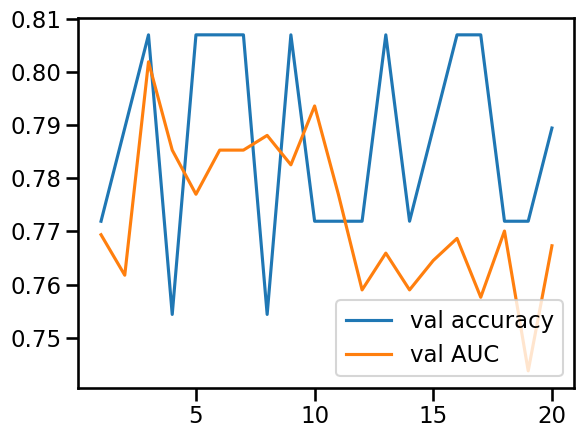

In [379]:
plt.plot(Cs, val_accs, label="val accuracy")
plt.plot(Cs, val_aucs, label="val AUC")
plt.legend()

In [380]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("test acc: ", val_accs[np.argmax(val_accs)])
print("test AUC ", val_aucs[np.argmax(val_accs)])

neigh = RandomForestClassifier(min_samples_leaf=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  3
test acc:  0.8070175438596491
test AUC  0.8019390581717452
test acc:  0.7894736842105263
test AUC  0.8808864265927977


In [607]:
## train RF w/ Kfold CV
val_accs = []
test_accs= []
val_aucs = []
Cs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
chosen_cs=[]
val_majclass_bline_accs = []
test_majclass_bline_accs = []
#k=9
for (train_index, test_index) in splits:

    val_accs_hparam_search = []

    #split test set into val and test halves
    val_index = test_index[:int(len(test_index)/2)]
    test_index = test_index[int(len(test_index)/2):]

    #calculate baseline performance - majority class
    majclass_bline_pred = targets[train_index].value_counts().index[targets[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets[val_index].value_counts()[majclass_bline_pred]/len(val_index))
    if majclass_bline_pred not in targets[test_index].value_counts().index:
        test_majclass_bline_accs.append(0)
    else:
        test_majclass_bline_accs.append(targets[test_index].value_counts()[majclass_bline_pred]/len(test_index))

    #tune hyperparam on this split's val set
    for c in Cs:
        neigh = RandomForestClassifier(min_samples_leaf=c)
        neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets[train_index])
        preds = neigh.predict(pseudobulk_input.iloc[val_index,:].dropna())
        val_acc = accuracy_score(targets[val_index], preds)
        val_accs_hparam_search.append(val_acc)
    bestc = Cs[np.argmax(val_accs_hparam_search)]
    chosen_cs.append(bestc)

    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets[train_index])

    #final val score
    preds = neigh.predict(pseudobulk_input.iloc[val_index,:].dropna())
    val_acc = accuracy_score(targets[val_index], preds)
    val_accs.append(val_acc)

    #final test score
    preds = neigh.predict(pseudobulk_input.iloc[test_index,:].dropna())
    test_acc = accuracy_score(targets[test_index], preds)
    test_accs.append(test_acc)

    #avoid error in roc_auc when only one class is present
    #val_auc = roc_auc_score(targets[test_index], neigh.predict_proba(pseudobulk_input.iloc[targets[test_index],:].dropna())[:,1])
    #val_aucs.append(val_auc)
    #plt.plot(Ks, val_accs)

In [608]:
print("mean val acc across folds: ", np.round(np.mean(val_accs),3))
print("mean majority class baseline val acc across folds: ", np.round(np.mean(val_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(val_accs, val_majclass_bline_accs)[1],3)))
print("\n")
print("mean test acc across folds: ", np.round(np.mean(test_accs),3))
print("mean majority class baseline test acc across folds: ", np.round(np.mean(test_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(test_accs, test_majclass_bline_accs)[1],3)))


mean val acc across folds:  0.561
mean majority class baseline val acc across folds:  0.637
wilcoxon signed-rank test p-value=0.317


mean test acc across folds:  0.674
mean majority class baseline test acc across folds:  0.721
wilcoxon signed-rank test p-value=0.317


/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


## create dataloader and train on fraction of each cell type

In [29]:
input_size = len(luca_adata.obs.cell_type.cat.categories)

## Input
celltype_counts_df = pd.DataFrame(luca_adata.obs.groupby('sample').cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index="sample", columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)

/tmp/ipykernel_1679613/2210525677.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_counts_df = pd.DataFrame(luca_adata.obs.groupby('sample').cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index="sample", columns="cell_type", values="cell_type_counts")


In [ ]:
## Create train, val, test datasets
train_input = celltype_fracs_df.loc[train_samples,:].dropna()
val_input = celltype_fracs_df.loc[val_samples,:].dropna()
test_input = celltype_fracs_df.loc[test_samples,:].dropna()

train_targets = torch.tensor(targets.loc[train_samples], dtype=torch.uint8)
val_targets = torch.tensor(targets.loc[val_samples], dtype=torch.uint8)
test_targets = torch.tensor(targets.loc[test_samples], dtype=torch.uint8)

train_dataset = TensorDataset(torch.Tensor(np.array(train_input)), train_targets)
val_dataset = TensorDataset(torch.Tensor(np.array(val_input)), val_targets)
test_dataset = TensorDataset(torch.Tensor(np.array(test_input)), test_targets)

## Create DataLoader for each split
#train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=True)

### KNN

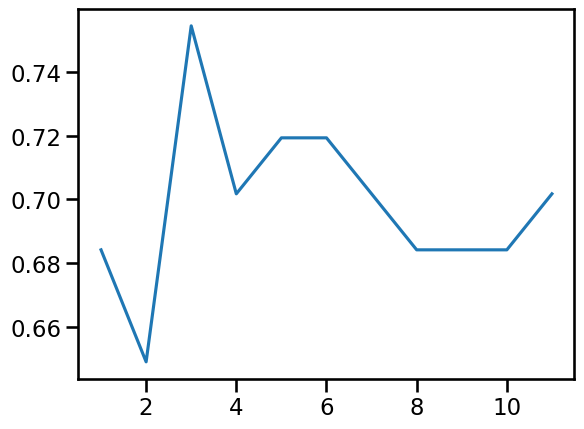

In [201]:
## train KNN
val_accs = []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1])
    #roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    val_aucs.append(val_auc)
plt.plot(Ks, val_accs)

In [202]:
bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC: ", val_aucs[np.argmax(val_accs)])

neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC: ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best K =  3
val acc:  0.7543859649122807
val AUC:  0.7555401662049861
test acc:  0.7192982456140351
test AUC:  0.8185595567867036


In [32]:
## train KNN w/ Kfold CV
val_accs = []
test_accs= []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
chosen_ks = []
val_majclass_bline_accs = []
test_majclass_bline_accs = []
#k=9
for (train_index, test_index) in splits:

    val_accs_hparam_search = []

    #split test set into val and test halves
    val_index = test_index[:int(len(test_index)/2)]
    test_index = test_index[int(len(test_index)/2):]

    #calculate baseline performance - majority class
    majclass_bline_pred = targets[train_index].value_counts().index[targets[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets[val_index].value_counts()[majclass_bline_pred]/len(val_index))
    if majclass_bline_pred not in targets[test_index].value_counts().index:
        test_majclass_bline_accs.append(0)
    else:
        test_majclass_bline_accs.append(targets[test_index].value_counts()[majclass_bline_pred]/len(test_index))

    for k in Ks:
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(celltype_fracs_df.iloc[train_index,:].dropna(), targets[train_index])
        preds = neigh.predict(celltype_fracs_df.iloc[val_index,:].dropna())
        val_acc = accuracy_score(targets[val_index], preds)
        val_accs_hparam_search.append(val_acc)

    bestk = Ks[np.argmax(val_accs_hparam_search)]
    chosen_ks.append(bestk)

    neigh = KNeighborsClassifier(n_neighbors=bestk)
    neigh.fit(celltype_fracs_df.iloc[train_index,:].dropna(), targets[train_index])

    #final val score
    preds = neigh.predict(celltype_fracs_df.iloc[val_index,:].dropna())
    val_acc = accuracy_score(targets[val_index], preds)
    val_accs.append(val_acc)

    #final test score
    preds = neigh.predict(celltype_fracs_df.iloc[test_index,:].dropna())
    test_acc = accuracy_score(targets[test_index], preds)
    test_accs.append(test_acc)

    #avoid error in roc_auc when only one class is present
    #val_auc = roc_auc_score(targets[test_index], neigh.predict_proba(pseudobulk_input.iloc[targets[test_index],:].dropna())[:,1])
    #val_aucs.append(val_auc)
    #plt.plot(Ks, val_accs)

/tmp/ipykernel_1679613/2884056029.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  majclass_bline_pred = targets[train_index].value_counts().index[targets[train_index].value_counts().argmax()]
/tmp/ipykernel_1679613/2884056029.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if majclass_bline_pred not in targets[val_index].value_counts().index:
/tmp/ipykernel_1679613/2884056029.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

In [33]:
print("mean val acc across folds: ", np.round(np.mean(val_accs),3))
print("mean majority class baseline val acc across folds: ", np.round(np.mean(val_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(val_accs, val_majclass_bline_accs)[1],3)))
print("\n")
print("mean test acc across folds: ", np.round(np.mean(test_accs),3))
print("mean majority class baseline test acc across folds: ", np.round(np.mean(test_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(test_accs, test_majclass_bline_accs)[1],3)))


mean val acc across folds:  0.662
mean majority class baseline val acc across folds:  0.637
wilcoxon signed-rank test p-value=0.553


mean test acc across folds:  0.532
mean majority class baseline test acc across folds:  0.721
wilcoxon signed-rank test p-value=0.064


### logistic regression 

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

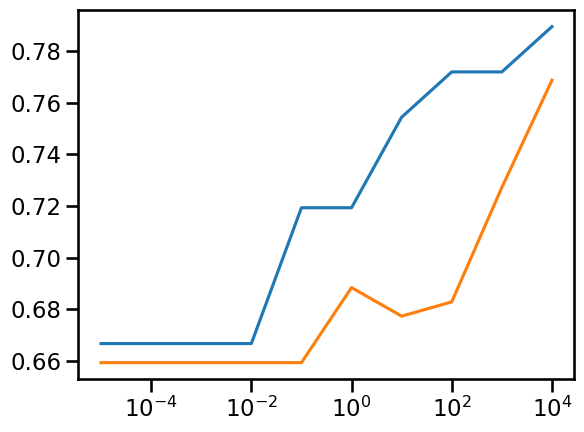

In [206]:
val_accs = []
val_aucs = []
Cs = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]
for c in Cs:
    neigh = LogisticRegression(C=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
plt.plot(Cs, val_accs)
plt.plot(Cs, val_aucs)
plt.xscale("log")

In [207]:
bestc = Cs[np.argmax(val_aucs)]
print("best C = ", bestc)
print("val acc: ", val_accs[np.argmax(val_aucs)])
print("val AUC ", val_aucs[np.argmax(val_aucs)])
neigh = LogisticRegression(C=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  10000
val acc:  0.7894736842105263
val AUC  0.7686980609418282
test acc:  0.7192982456140351
test AUC  0.7770083102493074


/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### random forest

In [203]:
val_accs = []
val_aucs = []
Cs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
for c in Cs:
    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))

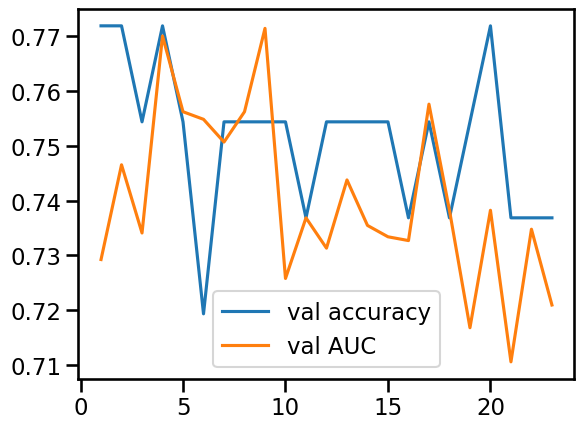

In [204]:
plt.plot(Cs, val_accs, label="val accuracy")
plt.plot(Cs, val_aucs, label="val AUC")
plt.legend()

In [205]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("test acc: ", val_accs[np.argmax(val_accs)])
print("test AUC ", val_aucs[np.argmax(val_accs)])

neigh = RandomForestClassifier(min_samples_leaf=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  1
test acc:  0.7719298245614035
test AUC  0.729224376731302
test acc:  0.7719298245614035
test AUC  0.8358725761772853


## create dataloader and train on fraction of each cell type + mean cell type embedding

In [110]:
#get cell type fracs
celltype_counts_df = pd.DataFrame(luca_adata.obs.groupby('sample').cell_type.value_counts()).reset_index().pivot(index="sample", columns="cell_type", values="count")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)
celltype_fracs_df.columns = [c+"_frac" for c in celltype_fracs_df.columns]

/tmp/ipykernel_928248/589063904.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_counts_df = pd.DataFrame(luca_adata.obs.groupby('sample').cell_type.value_counts()).reset_index().pivot(index="sample", columns="cell_type", values="count")


In [111]:
#get mean embedding per cell type

emb_name = 'X_scGPT'

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(luca_adata.obsm[emb_name], index=luca_adata.obs.index).merge(luca_adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index='sample', columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

/tmp/ipykernel_928248/106390764.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(luca_adata.obsm[emb_name], index=luca_adata.obs.index).merge(luca_adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()


In [112]:
# concat cell type fracs and mean embs dfs
celltype_fracs_means = celltype_fracs_df.merge(psblk_per_celltype, right_index=True, left_index=True)

In [113]:
# make sure that df is in the sample order as sample_pool, so that indexing using splits works properly
celltype_fracs_means = celltype_fracs_means.loc[sample_pool]

In [ ]:
## only run this if using the single train/test/val splitting strategy (not groupkfold)

## Create train, val, test datasets
train_input = celltype_fracs_means.loc[train_samples,:].dropna()
val_input = celltype_fracs_means.loc[val_samples,:].dropna()
test_input = celltype_fracs_means.loc[test_samples,:].dropna()

train_targets = torch.tensor(targets.loc[train_samples], dtype=torch.uint8)
val_targets = torch.tensor(targets.loc[val_samples], dtype=torch.uint8)
test_targets = torch.tensor(targets.loc[test_samples], dtype=torch.uint8)

train_dataset = TensorDataset(torch.Tensor(np.array(train_input)), train_targets)
val_dataset = TensorDataset(torch.Tensor(np.array(val_input)), val_targets)
test_dataset = TensorDataset(torch.Tensor(np.array(test_input)), test_targets)

## Create DataLoader for each split
#train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=True)

### KNN

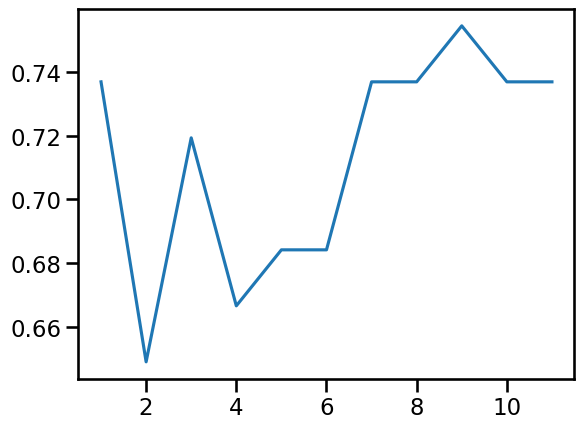

In [110]:
## train KNN
val_accs = []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1])
    #roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    val_aucs.append(val_auc)
plt.plot(Ks, val_accs)

In [111]:
bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC: ", val_aucs[np.argmax(val_accs)])

neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC: ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best K =  9
val acc:  0.7543859649122807
val AUC:  0.6752077562326871
test acc:  0.7719298245614035
test AUC:  0.8497229916897506


In [112]:
print("val (lower, mean, upper) 95% CI")
print(accuracy_confidence_interval(val_accs[np.argmax(val_accs)], len(val_dataset)))

val (lower, mean, upper) 95% CI
(0.64, 0.75, 0.87)


In [113]:
print("test (lower, mean, upper) 95% CI")
print(accuracy_confidence_interval(0.7719298245614035, len(test_dataset)))

test (lower, mean, upper) 95% CI
(0.66, 0.77, 0.88)


In [98]:
## train KNN w/ Kfold CV
val_accs = []
test_accs= []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
chosen_ks = []
val_majclass_bline_accs = []
test_majclass_bline_accs = []
#k=9
for (train_index, test_index) in splits:

    val_accs_hparam_search = []

    #split test set into val and test halves
    val_index = test_index[:int(len(test_index)/2)]
    test_index = test_index[int(len(test_index)/2):]
    #val_index = random.sample(list(test_index), int(len(test_index)/2))
    #test_index = test_index[~pd.Series(test_index).isin(val_index)]
    
    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))
    if majclass_bline_pred not in targets.iloc[test_index].value_counts().index:
        test_majclass_bline_accs.append(0)
    else:
        test_majclass_bline_accs.append(targets.iloc[test_index].value_counts()[majclass_bline_pred]/len(test_index))

    #hyperparam tuning on val set
    for k in Ks:
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(celltype_fracs_means.iloc[train_index,:].dropna(), targets.iloc[train_index])
        preds = neigh.predict(celltype_fracs_means.iloc[val_index,:].dropna())
        val_acc = accuracy_score(targets.iloc[val_index], preds)
        val_accs_hparam_search.append(val_acc)

    bestk = Ks[np.argmax(val_accs_hparam_search)]
    chosen_ks.append(bestk)

    #retrain model with best hyperparam
    neigh = KNeighborsClassifier(n_neighbors=bestk)
    neigh.fit(celltype_fracs_means.iloc[train_index,:].dropna(), targets.iloc[train_index])

    #final val score for fold
    preds = neigh.predict(celltype_fracs_means.iloc[val_index,:].dropna())
    val_acc = accuracy_score(targets.iloc[val_index], preds)
    val_accs.append(val_acc)

    #final test score for fold
    preds = neigh.predict(celltype_fracs_means.iloc[test_index,:].dropna())
    test_acc = accuracy_score(targets.iloc[test_index], preds)
    test_accs.append(test_acc)

In [99]:
chosen_ks

[3, 2, 9, 5, 2, 5, 7, 5, 1, 1]

In [100]:
print("mean val acc across folds: ", np.round(np.mean(val_accs),3))
print("mean majority class baseline val acc across folds: ", np.round(np.mean(val_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(val_accs, val_majclass_bline_accs)[1],3)))
print("\n")
print("mean test acc across folds: ", np.round(np.mean(test_accs),3))
print("mean majority class baseline test acc across folds: ", np.round(np.mean(test_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(test_accs, test_majclass_bline_accs)[1],3)))


mean val acc across folds:  0.84
mean majority class baseline val acc across folds:  0.692
wilcoxon signed-rank test p-value=0.08


mean test acc across folds:  0.69
mean majority class baseline test acc across folds:  0.668
wilcoxon signed-rank test p-value=0.573


### logistic regression

In [24]:
## train LR w/ Kfold CV
val_accs = []
test_accs= []
val_aucs = []
Cs = [1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]
chosen_cs=[]
val_majclass_bline_accs = []
test_majclass_bline_accs = []
#k=9
for (train_index, test_index) in splits:

    val_accs_hparam_search = []

    #split test set into val and test halves
    val_index = test_index[:int(len(test_index)/2)]
    test_index = test_index[int(len(test_index)/2):]
    #val_index = random.sample(list(test_index), int(len(test_index)/2))
    #test_index = test_index[~pd.Series(test_index).isin(val_index)]
    
    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))
    if majclass_bline_pred not in targets.iloc[test_index].value_counts().index:
        test_majclass_bline_accs.append(0)
    else:
        test_majclass_bline_accs.append(targets.iloc[test_index].value_counts()[majclass_bline_pred]/len(test_index))

    #tune hyperparam on this split's val set
    for c in Cs:
        neigh = LogisticRegression(C=c)
        neigh.fit(celltype_fracs_means.iloc[train_index,:].dropna(), targets.iloc[train_index])
        preds = neigh.predict(celltype_fracs_means.iloc[val_index,:].dropna())
        val_acc = accuracy_score(targets.iloc[val_index], preds)
        val_accs_hparam_search.append(val_acc)
    bestc = Cs[np.argmax(val_accs_hparam_search)]
    chosen_cs.append(bestc)

    neigh = LogisticRegression(C=bestc)
    neigh.fit(celltype_fracs_means.iloc[train_index,:].dropna(), targets.iloc[train_index])

    #final val score
    preds = neigh.predict(celltype_fracs_means.iloc[val_index,:].dropna())
    val_acc = accuracy_score(targets.iloc[val_index], preds)
    val_accs.append(val_acc)

    #final test score
    preds = neigh.predict(celltype_fracs_means.iloc[targets.iloc[test_index],:].dropna())
    test_acc = accuracy_score(targets.iloc[test_index], preds)
    test_accs.append(test_acc)


/opt/conda/rpeyser/envs/scgpt_3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/rpeyser/envs/scgpt_3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

In [25]:
chosen_cs

[0.01, 10, 0.1, 1e-10, 0.1, 1e-10, 1e-10, 100, 1, 1e-10]

In [26]:
print("mean val acc across folds: ", np.round(np.mean(val_accs),3))
print("mean majority class baseline val acc across folds: ", np.round(np.mean(val_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(val_accs, val_majclass_bline_accs)[1],3)))

mean val acc across folds:  0.743
mean majority class baseline val acc across folds:  0.637
wilcoxon signed-rank test p-value=0.027


In [27]:
print("mean test acc across folds: ", np.round(np.mean(test_accs),3))
print("mean majority class baseline test acc across folds: ", np.round(np.mean(test_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(test_accs, test_majclass_bline_accs)[1],3)))

mean test acc across folds:  0.645
mean majority class baseline test acc across folds:  0.721
wilcoxon signed-rank test p-value=0.317


#### with original single train/val/test split setup

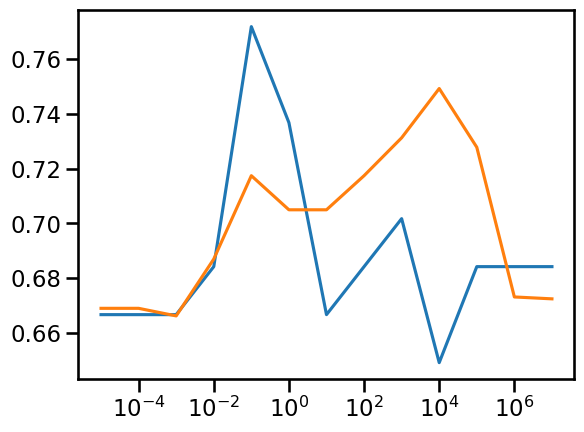

In [121]:
val_accs = []
val_aucs = []
Cs = [1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
for c in Cs:
    neigh = LogisticRegression(C=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
plt.plot(Cs, val_accs)
plt.plot(Cs, val_aucs)
plt.xscale("log")

In [122]:
bestc = Cs[np.argmax(val_aucs)]
print("best C = ", bestc)
print("val acc: ", val_accs[np.argmax(val_aucs)])
print("val AUC ", val_aucs[np.argmax(val_aucs)])
neigh = LogisticRegression(C=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  10000.0
val acc:  0.6491228070175439
val AUC  0.7493074792243767
test acc:  0.7192982456140351
test AUC  0.8074792243767314


### random forest

In [114]:
## train RF w/ Kfold CV
val_accs = []
test_accs= []
val_aucs = []
Cs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
chosen_cs=[]
val_majclass_bline_accs = []
test_majclass_bline_accs = []
#k=9
for (train_index, test_index) in splits:

    val_accs_hparam_search = []

    #split test set into val and test halves
    val_index = test_index[:int(len(test_index)/2)]
    test_index = test_index[int(len(test_index)/2):]

    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))
    if majclass_bline_pred not in targets.iloc[test_index].value_counts().index:
        test_majclass_bline_accs.append(0)
    else:
        test_majclass_bline_accs.append(targets.iloc[test_index].value_counts()[majclass_bline_pred]/len(test_index))

    #tune hyperparam on this split's val set
    for c in Cs:
        neigh = RandomForestClassifier(min_samples_leaf=c)
        neigh.fit(celltype_fracs_means.iloc[train_index,:].dropna(), targets.iloc[train_index])
        preds = neigh.predict(celltype_fracs_means.iloc[val_index,:].dropna())
        val_acc = accuracy_score(targets.iloc[val_index], preds)
        val_accs_hparam_search.append(val_acc)
    bestc = Cs[np.argmax(val_accs_hparam_search)]
    chosen_cs.append(bestc)

    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(celltype_fracs_means.iloc[train_index,:].dropna(), targets.iloc[train_index])

    #final val score
    preds = neigh.predict(celltype_fracs_means.iloc[val_index,:].dropna())
    val_acc = accuracy_score(targets.iloc[val_index], preds)
    val_accs.append(val_acc)

    #final test score
    preds = neigh.predict(celltype_fracs_means.iloc[test_index,:].dropna())
    test_acc = accuracy_score(targets.iloc[test_index], preds)
    test_accs.append(test_acc)


/tmp/ipykernel_928248/2999699899.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  majclass_bline_pred = targets[train_index].value_counts().index[targets[train_index].value_counts().argmax()]
/tmp/ipykernel_928248/2999699899.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if majclass_bline_pred not in targets[val_index].value_counts().index:
/tmp/ipykernel_928248/2999699899.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

In [115]:
print("mean val acc across folds: ", np.round(np.mean(val_accs),3))
print("mean majority class baseline val acc across folds: ", np.round(np.mean(val_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(val_accs, val_majclass_bline_accs)[1],3)))
print("\n")
print("mean test acc across folds: ", np.round(np.mean(test_accs),3))
print("mean majority class baseline test acc across folds: ", np.round(np.mean(test_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(test_accs, test_majclass_bline_accs)[1],3)))


mean val acc across folds:  0.659
mean majority class baseline val acc across folds:  0.637
wilcoxon signed-rank test p-value=0.5


mean test acc across folds:  0.658
mean majority class baseline test acc across folds:  0.721
wilcoxon signed-rank test p-value=1.0


# predict stage: early vs advanced - only include lung biopsies (pretty hard problem), tumor cells only

In [8]:
sample_col = 'sample'
target_col = 'tumor_stage'

#get sample IDs that are not NA for this target
notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
print("this target has {} non-NA samples".format(len(notNA_samples)))


this target has 555 non-NA samples


In [9]:
# dont include non-cancer samples
cancer_samples = luca_adata.obs.loc[luca_adata.obs.tumor_stage!="non-cancer",sample_col].drop_duplicates()

In [10]:
# only include lung samples
lung_samples = luca_adata.obs.loc[luca_adata.obs.tissue=="lung",sample_col].drop_duplicates()

In [17]:
#only keep samples that have >=n tumor cells. histogram of n tumor cells per sample, for samples with 0 > n < 100 cells. To help decide on cutoff
luca_malig_filter = pd.DataFrame(luca_adata.obs.groupby(["origin",sample_col]).cell_type.value_counts()).rename(columns={'cell_type':'cell_type_counts'})
luca_malig_filter = luca_malig_filter.reset_index()
luca_malig_filter = luca_malig_filter[((luca_malig_filter.origin=="tumor_primary") | (luca_malig_filter.origin=="tumor_metastasis")) & (luca_malig_filter.cell_type=="malignant cell") & (luca_malig_filter.cell_type_counts !=0)]

tumor_cell_samples = luca_malig_filter[luca_malig_filter.cell_type_counts >=15]['sample']

In [19]:
sample_pool = np.intersect1d(np.intersect1d(np.intersect1d(cancer_samples, notNA_samples), lung_samples), tumor_cell_samples)
print(len(sample_pool))

174


In [20]:
## Define targets
targets = luca_adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [21]:
labels

array(['advanced', 'early'], dtype=object)

In [22]:
targets.value_counts()/len(targets)

1    0.528736
0    0.471264
dtype: float64

In [23]:
#70/15/15 split
from sklearn.model_selection import train_test_split
trainvalsamples, test_samples= train_test_split(sample_pool, test_size=0.15, random_state=18, stratify=targets)
train_samples, val_samples = train_test_split(trainvalsamples, test_size=0.15/0.85, random_state=18, stratify=targets[trainvalsamples])
del trainvalsamples

## create dataloader and train on scANVI embeddings

In [24]:
emb_name = 'X_scANVI'
input_size = luca_adata.obsm[emb_name].shape[1]

#get sample IDs that are not NA for this target
#notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
#print("this target has {} non-NA samples".format(len(notNA_samples)))

## Input
# in this case, limiting pseudobulk input to only contain tumor cells
pseudobulk_input = pd.DataFrame(luca_adata.obsm[emb_name][luca_adata.obs.cell_type=="malignant cell",:], index=luca_adata.obs.loc[luca_adata.obs.cell_type=="malignant cell",sample_col]).reset_index().groupby(sample_col).mean()

## Create train, val, test datasets
train_input = pseudobulk_input.loc[train_samples,:].dropna()
val_input = pseudobulk_input.loc[val_samples,:].dropna()
test_input = pseudobulk_input.loc[test_samples,:].dropna()

train_targets = torch.tensor(targets.loc[train_samples], dtype=torch.uint8)
val_targets = torch.tensor(targets.loc[val_samples], dtype=torch.uint8)
test_targets = torch.tensor(targets.loc[test_samples], dtype=torch.uint8)

train_dataset = TensorDataset(torch.Tensor(np.array(train_input)), train_targets)
val_dataset = TensorDataset(torch.Tensor(np.array(val_input)), val_targets)
test_dataset = TensorDataset(torch.Tensor(np.array(test_input)), test_targets)

## Create DataLoader for each split
#train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=True)

In [25]:
pd.Series(train_targets).value_counts()

1    64
0    57
dtype: int64

In [26]:
pd.Series(val_targets).value_counts()

1    14
0    12
dtype: int64

In [27]:
pd.Series(test_targets).value_counts()

1    14
0    13
dtype: int64

### majority class

In [28]:
pd.Series(val_targets).value_counts()/len(val_targets)

1    0.538462
0    0.461538
dtype: float64

In [29]:
pd.Series(test_targets).value_counts()/len(test_targets)

1    0.518519
0    0.481481
dtype: float64

### KNN

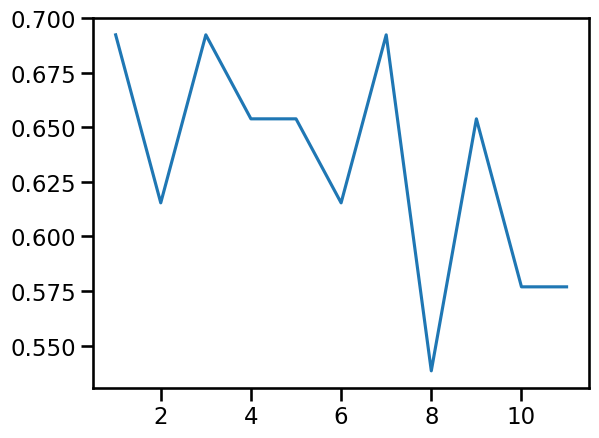

In [30]:
## train KNN
val_accs = []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1])
    #roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    val_aucs.append(val_auc)
plt.plot(Ks, val_accs)

In [32]:
bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC: ", val_aucs[np.argmax(val_accs)])

neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC: ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best K =  1
val acc:  0.6923076923076923
val AUC:  0.6904761904761906
test acc:  0.7037037037037037
test AUC:  0.7005494505494506


### logistic regression 

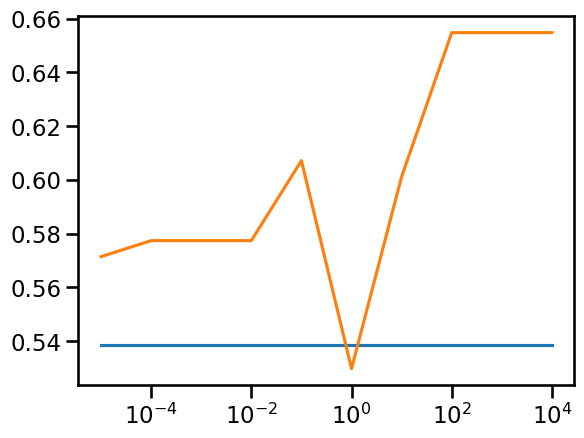

In [38]:
val_accs = []
val_aucs = []
Cs = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]
for c in Cs:
    neigh = LogisticRegression(C=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
plt.plot(Cs, val_accs)
plt.plot(Cs, val_aucs)
plt.xscale("log")

In [39]:
bestc = Cs[np.argmax(val_aucs)]
print("best C = ", bestc)
print("val acc: ", val_accs[np.argmax(val_aucs)])
print("val AUC ", val_aucs[np.argmax(val_aucs)])
neigh = LogisticRegression(C=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  100
val acc:  0.5384615384615384
val AUC  0.6547619047619048
test acc:  0.5185185185185185
test AUC  0.554945054945055


### random forest

In [33]:
val_accs = []
val_aucs = []
Cs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for c in Cs:
    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))

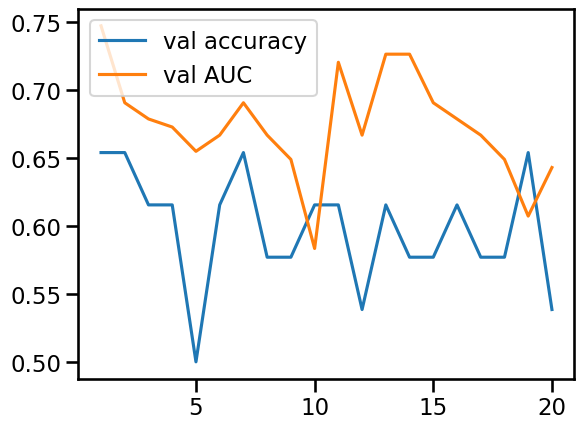

In [34]:
plt.plot(Cs, val_accs, label="val accuracy")
plt.plot(Cs, val_aucs, label="val AUC")
plt.legend()

In [35]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("test acc: ", val_accs[np.argmax(val_accs)])
print("test AUC ", val_aucs[np.argmax(val_accs)])

neigh = RandomForestClassifier(min_samples_leaf=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  1
test acc:  0.6538461538461539
test AUC  0.7470238095238095
test acc:  0.6296296296296297
test AUC  0.6703296703296703


## create dataloader and train on scGPT embeddings

In [41]:
emb_name = 'X_scGPT'
input_size = luca_adata.obsm[emb_name].shape[1]

#get sample IDs that are not NA for this target
#notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
#print("this target has {} non-NA samples".format(len(notNA_samples)))

## Input
pseudobulk_input = pd.DataFrame(luca_adata.obsm[emb_name][luca_adata.obs.cell_type=="malignant cell",:], index=luca_adata.obs.loc[luca_adata.obs.cell_type=="malignant cell",sample_col]).reset_index().groupby(sample_col).mean()

## Create train, val, test datasets
train_input = pseudobulk_input.loc[train_samples,:].dropna()
val_input = pseudobulk_input.loc[val_samples,:].dropna()
test_input = pseudobulk_input.loc[test_samples,:].dropna()

train_targets = torch.tensor(targets.loc[train_samples], dtype=torch.uint8)
val_targets = torch.tensor(targets.loc[val_samples], dtype=torch.uint8)
test_targets = torch.tensor(targets.loc[test_samples], dtype=torch.uint8)

train_dataset = TensorDataset(torch.Tensor(np.array(train_input)), train_targets)
val_dataset = TensorDataset(torch.Tensor(np.array(val_input)), val_targets)
test_dataset = TensorDataset(torch.Tensor(np.array(test_input)), test_targets)

## Create DataLoader for each split
#train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=True)

### KNN

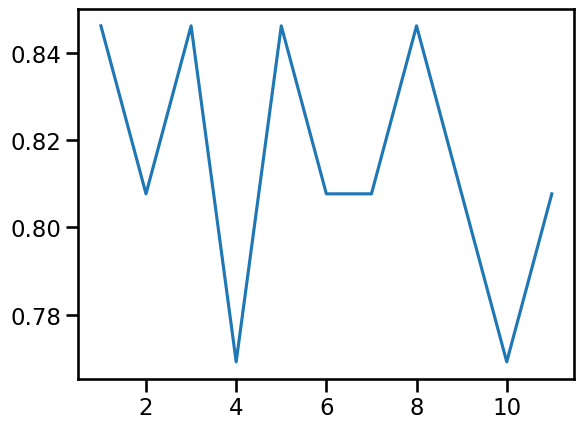

In [42]:
## train KNN
val_accs = []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1])
    #roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    val_aucs.append(val_auc)
plt.plot(Ks, val_accs)

In [43]:
bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC: ", val_aucs[np.argmax(val_accs)])

neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC: ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best K =  1
val acc:  0.8461538461538461
val AUC:  0.8452380952380952
test acc:  0.8148148148148148
test AUC:  0.8131868131868132


### logistic regression 

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

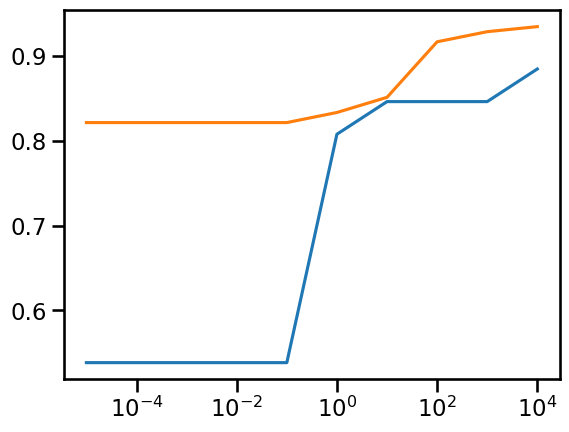

In [46]:
val_accs = []
val_aucs = []
Cs = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]
for c in Cs:
    neigh = LogisticRegression(C=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
plt.plot(Cs, val_accs)
plt.plot(Cs, val_aucs)
plt.xscale("log")

In [45]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC ", val_aucs[np.argmax(val_accs)])
neigh = LogisticRegression(C=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  10000
val acc:  0.8846153846153846
val AUC  0.9345238095238095
test acc:  0.8148148148148148
test AUC  0.8241758241758241


/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### random forest

In [47]:
val_accs = []
val_aucs = []
Cs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for c in Cs:
    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))

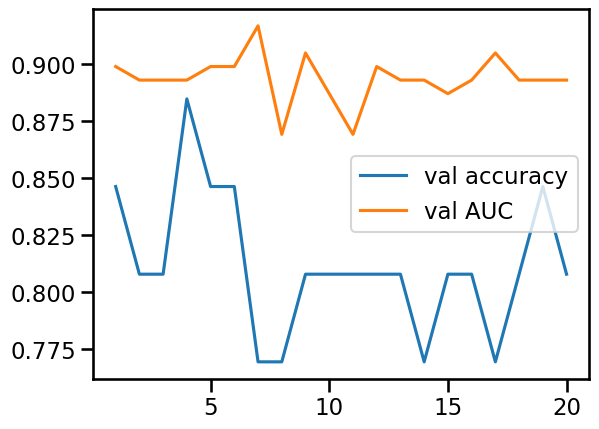

In [48]:
plt.plot(Cs, val_accs, label="val accuracy")
plt.plot(Cs, val_aucs, label="val AUC")
plt.legend()

In [49]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("test acc: ", val_accs[np.argmax(val_accs)])
print("test AUC ", val_aucs[np.argmax(val_accs)])

neigh = RandomForestClassifier(min_samples_leaf=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  4
test acc:  0.8846153846153846
test AUC  0.8928571428571428
test acc:  0.7037037037037037
test AUC  0.7362637362637362


# predict stage: early vs advanced - only include lung biopsies (pretty hard problem), immune cells only

In [153]:
sample_col = 'sample'
target_col = 'tumor_stage'

#get sample IDs that are not NA for this target
notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
print("this target has {} non-NA samples".format(len(notNA_samples)))


this target has 555 non-NA samples


In [154]:
# dont include non-cancer samples
cancer_samples = luca_adata.obs.loc[luca_adata.obs.tumor_stage!="non-cancer",sample_col].drop_duplicates()

In [155]:
# only include lung samples
lung_samples = luca_adata.obs.loc[luca_adata.obs.tissue=="lung",sample_col].drop_duplicates()

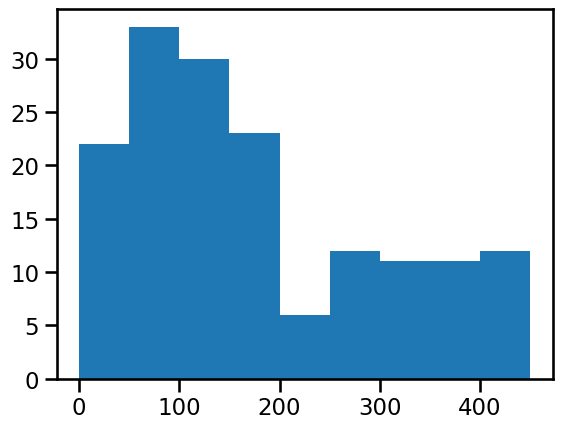

In [156]:
# make sure sample has immune cells
luca_adata.obs.cell_type.value_counts()

nonimmune_celltypes = ["malignant cell", "epithelial cell of lung", "epithelial cell of lung", "multi-ciliated epithelial cell", "fibroblast of lung", 
                       "endothelial cell of lymphatic vessel", "bronchus fibroblast of lung", "pulmonary artery endothelial cell", "smooth muscle cell", 
                       "pericyte", "club cell", "mesothelial cell", "stromal cell", "vein endothelial cell", "capillary endothelial cell"]
immune_samples = luca_adata.obs[~luca_adata.obs.cell_type.isin(nonimmune_celltypes)].groupby("sample").size()#.sort_values()[:20]

plt.hist(immune_samples[immune_samples<500], bins=np.arange(0,500,50));

In [157]:
# only keep samples with at least 50 immune cells
immune_samples = list(immune_samples[immune_samples>=50].index)


In [158]:
sample_pool = np.intersect1d(np.intersect1d(np.intersect1d(cancer_samples, notNA_samples), lung_samples), immune_samples)
print(len(sample_pool))

360


In [159]:
## Define targets
targets = luca_adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [160]:
labels

array(['advanced', 'early'], dtype=object)

In [161]:
targets.value_counts()/len(targets)

1    0.669444
0    0.330556
dtype: float64

In [162]:
#70/15/15 split
from sklearn.model_selection import train_test_split
trainvalsamples, test_samples= train_test_split(sample_pool, test_size=0.15, random_state=18, stratify=targets)
train_samples, val_samples = train_test_split(trainvalsamples, test_size=0.15/0.85, random_state=18, stratify=targets[trainvalsamples])
del trainvalsamples

### majority class

In [163]:
pd.Series(val_targets).value_counts()/len(val_targets)

1    0.666667
0    0.333333
dtype: float64

In [164]:
pd.Series(test_targets).value_counts()/len(test_targets)

1    0.672727
0    0.327273
dtype: float64

## create dataloader and train on scANVI embeddings

In [165]:
emb_name = 'X_scANVI'
input_size = luca_adata.obsm[emb_name].shape[1]

#get sample IDs that are not NA for this target
#notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
#print("this target has {} non-NA samples".format(len(notNA_samples)))

## Input - limit to immue sells only
pseudobulk_input = pd.DataFrame(luca_adata.obsm[emb_name][~luca_adata.obs.cell_type.isin(nonimmune_celltypes),:], index=luca_adata.obs.loc[~luca_adata.obs.cell_type.isin(nonimmune_celltypes),sample_col]).reset_index().groupby(sample_col).mean()

## Create train, val, test datasets
train_input = pseudobulk_input.loc[train_samples,:].dropna()
val_input = pseudobulk_input.loc[val_samples,:].dropna()
test_input = pseudobulk_input.loc[test_samples,:].dropna()

train_targets = torch.tensor(targets.loc[train_samples], dtype=torch.uint8)
val_targets = torch.tensor(targets.loc[val_samples], dtype=torch.uint8)
test_targets = torch.tensor(targets.loc[test_samples], dtype=torch.uint8)

train_dataset = TensorDataset(torch.Tensor(np.array(train_input)), train_targets)
val_dataset = TensorDataset(torch.Tensor(np.array(val_input)), val_targets)
test_dataset = TensorDataset(torch.Tensor(np.array(test_input)), test_targets)

## Create DataLoader for each split
#train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=True)

In [112]:
pd.Series(train_targets).value_counts()

1    169
0     83
dtype: int64

In [113]:
pd.Series(val_targets).value_counts()

1    36
0    18
dtype: int64

In [114]:
pd.Series(test_targets).value_counts()

1    37
0    18
dtype: int64

### KNN

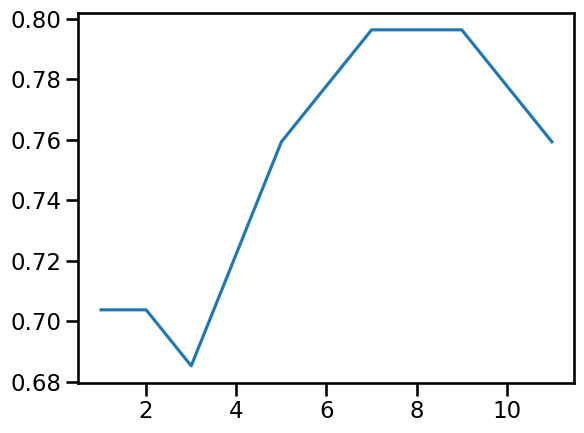

In [166]:
## train KNN
val_accs = []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1])
    #roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    val_aucs.append(val_auc)
plt.plot(Ks, val_accs)

In [167]:
bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC: ", val_aucs[np.argmax(val_accs)])

neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC: ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best K =  7
val acc:  0.7962962962962963
val AUC:  0.7970679012345678
test acc:  0.6851851851851852
test AUC:  0.7685185185185185


### logistic regression 

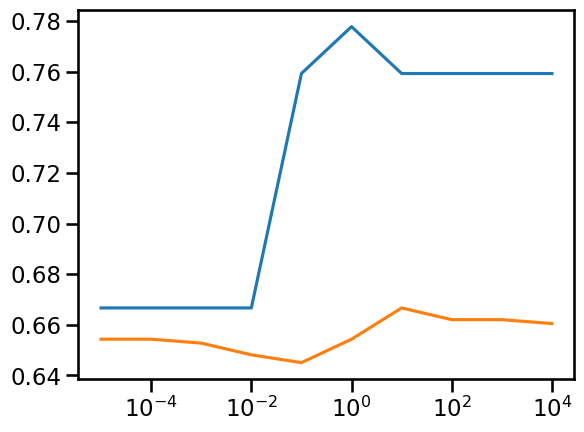

In [171]:
val_accs = []
val_aucs = []
Cs = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]
for c in Cs:
    neigh = LogisticRegression(C=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
plt.plot(Cs, val_accs)
plt.plot(Cs, val_aucs)
plt.xscale("log")

In [172]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC ", val_aucs[np.argmax(val_accs)])
neigh = LogisticRegression(C=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  1
val acc:  0.7777777777777778
val AUC  0.654320987654321
test acc:  0.6851851851851852
test AUC  0.6635802469135803


### random forest

In [168]:
val_accs = []
val_aucs = []
Cs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for c in Cs:
    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))

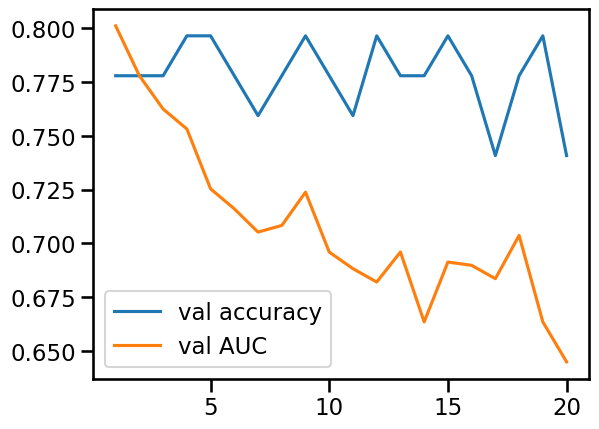

In [169]:
plt.plot(Cs, val_accs, label="val accuracy")
plt.plot(Cs, val_aucs, label="val AUC")
plt.legend()

In [170]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("test acc: ", val_accs[np.argmax(val_accs)])
print("test AUC ", val_aucs[np.argmax(val_accs)])

neigh = RandomForestClassifier(min_samples_leaf=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  4
test acc:  0.7962962962962963
test AUC  0.7530864197530864
test acc:  0.7037037037037037
test AUC  0.6975308641975309


## create dataloader and train on scGPT embeddings

In [173]:
emb_name = 'X_scGPT'
input_size = luca_adata.obsm[emb_name].shape[1]

#get sample IDs that are not NA for this target
#notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
#print("this target has {} non-NA samples".format(len(notNA_samples)))

## Input
pseudobulk_input = pd.DataFrame(luca_adata.obsm[emb_name][~luca_adata.obs.cell_type.isin(nonimmune_celltypes),:], index=luca_adata.obs.loc[~luca_adata.obs.cell_type.isin(nonimmune_celltypes),sample_col]).reset_index().groupby(sample_col).mean()

## Create train, val, test datasets
train_input = pseudobulk_input.loc[train_samples,:].dropna()
val_input = pseudobulk_input.loc[val_samples,:].dropna()
test_input = pseudobulk_input.loc[test_samples,:].dropna()

train_targets = torch.tensor(targets.loc[train_samples], dtype=torch.uint8)
val_targets = torch.tensor(targets.loc[val_samples], dtype=torch.uint8)
test_targets = torch.tensor(targets.loc[test_samples], dtype=torch.uint8)

train_dataset = TensorDataset(torch.Tensor(np.array(train_input)), train_targets)
val_dataset = TensorDataset(torch.Tensor(np.array(val_input)), val_targets)
test_dataset = TensorDataset(torch.Tensor(np.array(test_input)), test_targets)

## Create DataLoader for each split
#train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=True)

### KNN

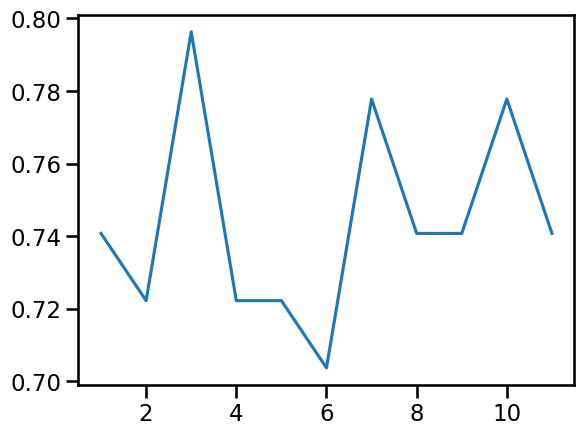

In [174]:
## train KNN
val_accs = []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1])
    #roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    val_aucs.append(val_auc)
plt.plot(Ks, val_accs)

In [175]:
bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC: ", val_aucs[np.argmax(val_accs)])

neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC: ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best K =  3
val acc:  0.7962962962962963
val AUC:  0.8441358024691359
test acc:  0.7777777777777778
test AUC:  0.7916666666666666


### logistic regression 

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

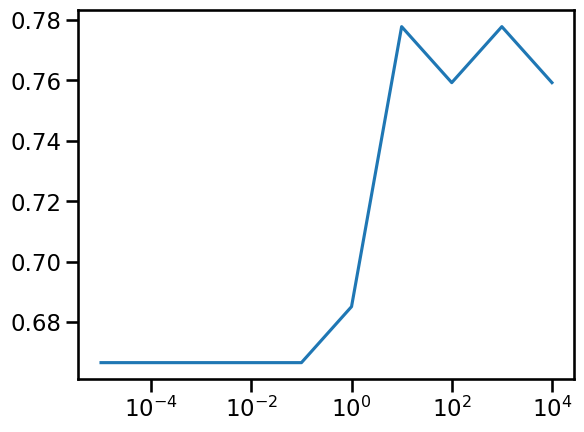

In [179]:
val_accs = []
val_aucs = []
Cs = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]
for c in Cs:
    neigh = LogisticRegression(C=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
plt.plot(Cs, val_accs)
plt.xscale("log")

In [180]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC ", val_aucs[np.argmax(val_accs)])
neigh = LogisticRegression(C=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  10
val acc:  0.7777777777777778
val AUC  0.8148148148148149
test acc:  0.7962962962962963
test AUC  0.8549382716049382


/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### random forest

In [176]:
val_accs = []
val_aucs = []
Cs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for c in Cs:
    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))

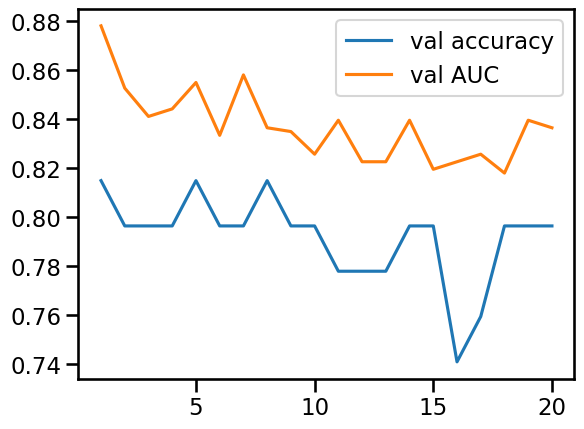

In [177]:
plt.plot(Cs, val_accs, label="val accuracy")
plt.plot(Cs, val_aucs, label="val AUC")
plt.legend()

In [178]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("test acc: ", val_accs[np.argmax(val_accs)])
print("test AUC ", val_aucs[np.argmax(val_accs)])

neigh = RandomForestClassifier(min_samples_leaf=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  1
test acc:  0.8148148148148148
test AUC  0.8780864197530865
test acc:  0.7592592592592593
test AUC  0.8070987654320987


## create dataloader and train on fraction of each cell type

In [181]:
luca_adata.obs[~luca_adata.obs.cell_type.isin(nonimmune_celltypes)].cell_type.value_counts()

CD4-positive, alpha-beta T cell         199444
CD8-positive, alpha-beta T cell         160394
alveolar macrophage                     147293
macrophage                              114381
classical monocyte                       86641
natural killer cell                      74816
B cell                                   69007
type II pneumocyte                       47999
regulatory T cell                        40051
plasma cell                              35538
CD1c-positive myeloid dendritic cell     28882
mast cell                                19838
neutrophil                               19368
non-classical monocyte                    9189
myeloid cell                              7663
type I pneumocyte                         7230
plasmacytoid dendritic cell               5051
conventional dendritic cell               3039
dendritic cell                            2406
vein endothelial cell                        0
endothelial cell of lymphatic vessel         0
pulmonary art

In [182]:
input_size = len(luca_adata.obs.cell_type.cat.categories)

## Input
celltype_counts_df = pd.DataFrame(luca_adata.obs[~luca_adata.obs.cell_type.isin(nonimmune_celltypes)].groupby('sample').cell_type.value_counts()).rename({'cell_type':'cell_type_counts'},axis=1).reset_index().pivot(index="sample", columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)

## Create train, val, test datasets
train_input = celltype_fracs_df.loc[train_samples,:].dropna()
val_input = celltype_fracs_df.loc[val_samples,:].dropna()
test_input = celltype_fracs_df.loc[test_samples,:].dropna()

train_targets = torch.tensor(targets.loc[train_samples], dtype=torch.uint8)
val_targets = torch.tensor(targets.loc[val_samples], dtype=torch.uint8)
test_targets = torch.tensor(targets.loc[test_samples], dtype=torch.uint8)

train_dataset = TensorDataset(torch.Tensor(np.array(train_input)), train_targets)
val_dataset = TensorDataset(torch.Tensor(np.array(val_input)), val_targets)
test_dataset = TensorDataset(torch.Tensor(np.array(test_input)), test_targets)

## Create DataLoader for each split
#train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=True)

### KNN

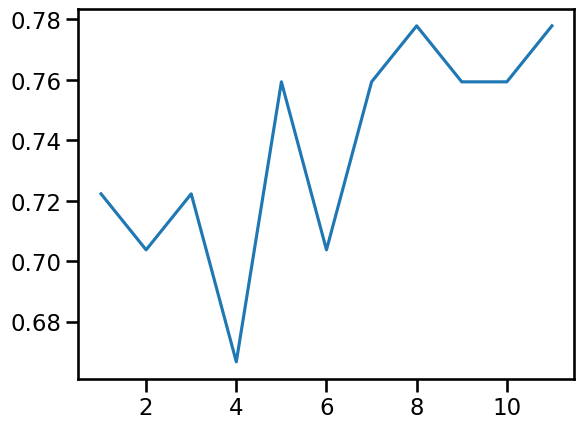

In [183]:
## train KNN
val_accs = []
val_aucs = []
Ks = [1,2,3,4,5,6,7,8,9,10,11]
for k in Ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_auc = roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1])
    #roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
    val_aucs.append(val_auc)
plt.plot(Ks, val_accs)

In [184]:
bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC: ", val_aucs[np.argmax(val_accs)])

neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC: ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best K =  8
val acc:  0.7777777777777778
val AUC:  0.7283950617283951
test acc:  0.6481481481481481
test AUC:  0.7330246913580246


### logistic regression 

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

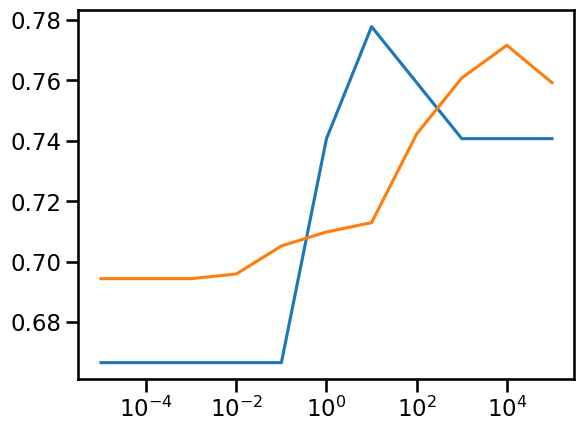

In [190]:
val_accs = []
val_aucs = []
Cs = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000,100000]
for c in Cs:
    neigh = LogisticRegression(C=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
plt.plot(Cs, val_accs)
plt.plot(Cs, val_aucs)
plt.xscale("log")

In [191]:
bestc = Cs[np.argmax(val_aucs)]
print("best C = ", bestc)
print("val acc: ", val_accs[np.argmax(val_aucs)])
print("val AUC ", val_aucs[np.argmax(val_aucs)])
neigh = LogisticRegression(C=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  10000
val acc:  0.7407407407407407
val AUC  0.7716049382716049
test acc:  0.6851851851851852
test AUC  0.7314814814814815


/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### random forest

In [185]:
val_accs = []
val_aucs = []
Cs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
for c in Cs:
    neigh = RandomForestClassifier(min_samples_leaf=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))

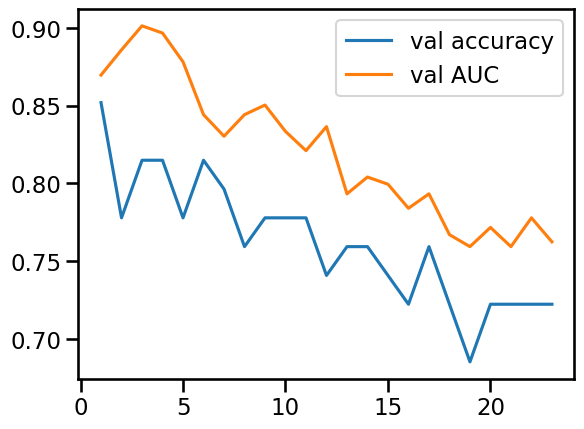

In [186]:
plt.plot(Cs, val_accs, label="val accuracy")
plt.plot(Cs, val_aucs, label="val AUC")
plt.legend()

In [187]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("test acc: ", val_accs[np.argmax(val_accs)])
print("test AUC ", val_aucs[np.argmax(val_accs)])

neigh = RandomForestClassifier(min_samples_leaf=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  1
test acc:  0.8518518518518519
test AUC  0.8695987654320988
test acc:  0.7222222222222222
test AUC  0.8148148148148149


# below here is old

## stratify train/test split by study

In [5]:
import random
random.seed(18)
remaining_studies = list(luca_adata.obs['study'].drop_duplicates())
train_studies = random.sample(remaining_studies, int(0.7 * len(remaining_studies)))

remaining_studies = list(np.setdiff1d(remaining_studies, train_studies))
val_studies = random.sample(remaining_studies, int(len(remaining_studies)/2))

test_studies = list(np.setdiff1d(remaining_studies, val_studies))

In [6]:
# manually inspect and make sure that val/test doesnt contain seq protocols not included in train, to avoid dataset shift

In [7]:
luca_adata.obs[['sample','study','assay']].drop_duplicates()[['study','assay']].value_counts()[train_studies]

study                      assay                                   
Kim_Lee_2020               10x 3' v2                                   58
Guo_Zhang_2018             Smart-seq2                                  63
UKIM-V                     BD Rhapsody Whole Transcriptome Analysis    34
Maynard_Bivona_2020        Smart-seq2                                  42
Zilionis_Klein_2019        inDrop                                      18
Wu_Zhou_2021               GEXSCOPE technology                         42
Lambrechts_Thienpont_2018  10x 3' v2                                   24
                           10x 3' v1                                    7
Vieira_Teichmann_2019      Drop-seq                                     4
Reyfman_Misharin_2018      10x 3' v2                                    8
Goveia_Carmeliet_2020      10x 3' v2                                   13
Mayr_Schiller_2020         Drop-seq                                    10
Habermann_Kropski_2020     10x 5' v1        

In [8]:
luca_adata.obs[['sample','study','assay']].drop_duplicates()[['study','assay']].value_counts()[val_studies]

study                 assay    
He_Fan_2021           10x 3' v2    10
Chen_Zhang_2020       10x 3' v3     6
                      10x 3' v2     5
Madissoon_Meyer_2020  10x 3' v2    19
dtype: int64

In [9]:
luca_adata.obs[['sample','study','assay']].drop_duplicates()[['study','assay']].value_counts()[test_studies]

study                   assay    
Adams_Kaminski_2020     10x 3' v2    62
Laughney_Massague_2020  10x 3' v2    17
Leader_Merad_2021       10x 3' v2    87
                        10x 5' v1     6
                        10x 3' v3     2
                        10x 3' v1     2
dtype: int64

In [6]:
# move Leader_Merad_2021 into train set to increase training size
train_studies.append('Leader_Merad_2021')
test_studies = list(np.setdiff1d(test_studies, 'Leader_Merad_2021'))

## define NNs for diff outcomes

In [167]:
class SimpleNN_age(pl.LightningModule):
    def __init__(self, input_size, hidden1_size=30, hidden2_size=15, output_size=1, lr=0.01):#, data_name=None, model_name=None):
        super(SimpleNN_age, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, output_size)
        self.lr = lr
        #self.logger = pl.loggers.TensorBoardLogger("logs/", name=data_name, version=model_name) #does it need to be self.logger?

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = nn.MSELoss()(outputs, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        #accuracy = (predicted == y).sum().item() / y.size(0)
        MAE = nn.L1Loss()(outputs, y)
        self.log('train_MAE', MAE, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        val_loss = nn.MSELoss()(outputs, y)
        self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)  # Log validation loss
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        MAE = nn.L1Loss()(outputs, y)
        self.log('val_MAE', MAE, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return val_loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

#### predict age

In [172]:
### create dataloader

input_size = 512 #length of scGPT embeddings
sample_col = 'sample'
target_col = 'age'
bsize = 32 

#get sample IDs that are not NA for this target
notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]#[target_col]#]#sample_col]
print("this target has {} non-NA samples".format(len(notNA_samples)))

#input
pseudobulk_input = pd.DataFrame(luca_adata.obsm['X_scGPT'], index=luca_adata.obs[sample_col]).reset_index().groupby(sample_col).mean()
pseudobulk_input = pseudobulk_input.loc[notNA_samples]

#define targets
targets = luca_adata.obs[[sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[notNA_samples][target_col]
targets = torch.tensor(targets, dtype=torch.float).unsqueeze(dim=1)

#put inputs and targets in the same order
#not nec now that both are limited to and ordered by notNA_samples

# Combine input features and target into a TensorDataset
dataset = TensorDataset(torch.Tensor(np.array(pseudobulk_input)), targets)

# Define the sizes of the train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create the splits
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=bsize, shuffle=True)
val_loader = DataLoader(val_data, batch_size=bsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=bsize, shuffle=True)

this target has 450 non-NA samples


In [169]:
### train model

# Initialize the Lightning model
lr = 0.001
logger = pl.loggers.TensorBoardLogger('logs/', name="luca_age_3layers_scGPTembeds_mean_lr{}_bs{}".format(lr, bsize), version=datetime.now().strftime("%Y%m%d-%H%M%S"))
model = SimpleNN_age(input_size, hidden1_size=256, hidden2_size=128, output_size=1, lr=lr)

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=250,logger=logger)

# Train the model
trainer.fit(model, train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name  | Type   | Params
---------------------------------
0 | fc1   | Linear | 131 K 
1 | relu1 | ReLU   | 0     
2 | fc2   | Linear | 32.9 K
3 | relu2 | ReLU   | 0     
4 | fc3   | Linear | 129   
---------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.657     Total estimated model params size (MB)


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 81.48it/s, v_num=4511]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|████████| 10/10 [00:00<00:00, 85.28it/s, v_num=4511, val_loss=3.79e+3, val_MAE=59.80, train_loss=4.11e+3, train_MAE=62.90]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|████████| 10/10 [00:00<00:00, 85.51it/s, v_num=4511, val_loss=3.64e+3, val_MAE=58.50, train_loss=4.02e+3, train_MAE=62.20]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|████████| 10/10 [00:00<00:00, 86.52it/s, v_num=4511, val_loss=3.29e+3, val_MAE=55.40, train_loss=3.77e+3, train_MAE=60.20]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|████████| 10/10 [00:00<00:00, 87.38it/s, v_num=4511, val_loss=2.66e+3, val_MAE=49.40, train_loss=3.28e+3, train_MAE=55.90]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|████████| 10/10 [00:00<00:00, 85.71it/s, v_num=4511, val_loss=1.75e+3, val_MAE=39.20, train_loss=2.48e+3, train_MAE=48.10]
Validation: 0it [00:00,

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 29.74it/s, v_num=4511, val_loss=129.0, val_MAE=9.110, train_loss=76.50, train_MAE=6.910]


In [170]:
print(trainer.callback_metrics)

{'val_loss': tensor(128.7906), 'val_MAE': tensor(9.1061), 'train_loss': tensor(76.5203), 'train_MAE': tensor(6.9104)}


#### KNN Regressor to predict age

In [ ]:
### create dataloader

input_size = 512 #length of scGPT embeddings
sample_col = 'sample'
target_col = 'age'
bsize = 32 

#get sample IDs that are not NA for this target
notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]#[target_col]#]#sample_col]
print("this target has {} non-NA samples".format(len(notNA_samples)))

#input
pseudobulk_input = pd.DataFrame(luca_adata.obsm['X_scGPT'], index=luca_adata.obs[sample_col]).reset_index().groupby(sample_col).mean()
pseudobulk_input = pseudobulk_input.loc[notNA_samples]

#define targets
targets = luca_adata.obs[[sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[notNA_samples][target_col]
targets = torch.tensor(targets, dtype=torch.float).unsqueeze(dim=1)

#put inputs and targets in the same order
#not nec now that both are limited to and ordered by notNA_samples

# Combine input features and target into a TensorDataset
dataset = TensorDataset(torch.Tensor(np.array(pseudobulk_input)), targets)

# Define the sizes of the train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create the splits
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=bsize, shuffle=True)
val_loader = DataLoader(val_data, batch_size=bsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=bsize, shuffle=True)

In [195]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

val_MAEs = []
Ks = [5,6,7,8,9,11]
for k in Ks:
    print("nneighbors ", k)
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(train_data[:][0], train_data[:][1])
    preds = neigh.predict(val_data[:][0])
    val_MAE = mean_absolute_error(val_data[:][1], preds)
    val_MAEs.append(val_MAE)
    print("val MAE ", val_MAE)
    print("\n")

bestk = Ks[np.argmin(val_MAEs)]
print("best K = ", bestk)
neigh = KNeighborsRegressor(n_neighbors=bestk)
neigh.fit(train_data[:][0], train_data[:][1])
preds = neigh.predict(test_data[:][0])
print("test MAE: ", mean_absolute_error(test_data[:][1], preds))



nneighbors  5
val MAE  9.480598


nneighbors  6
val MAE  9.20398


nneighbors  7
val MAE  8.976545


nneighbors  8
val MAE  9.106343


nneighbors  9
val MAE  9.202322


nneighbors  11
val MAE  9.30665


best K =  7
test MAE:  6.6974792


#### stage

In [216]:
### create dataloader

input_size = 512 #length of scGPT embeddings
sample_col = 'sample'
target_col = 'uicc_stage'
bsize = 32 

#get sample IDs that are not NA for this target
notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]#[target_col]#]#sample_col]
print("this target has {} non-NA samples".format(len(notNA_samples)))

#input
pseudobulk_input = pd.DataFrame(luca_adata.obsm['X_scGPT'], index=luca_adata.obs[sample_col]).reset_index().groupby(sample_col).mean()
pseudobulk_input = pseudobulk_input.loc[notNA_samples]

#define targets
targets = luca_adata.obs[[sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[notNA_samples][target_col]
labels, targets = np.unique(targets, return_inverse=True)
targets = torch.tensor(targets, dtype=torch.uint8)
#targets = torch.tensor(targets).unsqueeze(dim=1)

#put inputs and targets in the same order
#not nec now that both are limited to and ordered by notNA_samples

# Combine input features and target into a TensorDataset
dataset = TensorDataset(torch.Tensor(np.array(pseudobulk_input)), targets)

# Define the sizes of the train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create the splits
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=bsize, shuffle=True)
val_loader = DataLoader(val_data, batch_size=bsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=bsize, shuffle=True)

this target has 555 non-NA samples


In [219]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

val_accs = []
Ks = [3,4,5,6,7]
for k in Ks:
    print("nneighbors ", k)
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_data[:][0], train_data[:][1])
    preds = neigh.predict(val_data[:][0])

    val_acc = accuracy_score(val_data[:][1], preds)
    val_accs.append(val_acc)
    print("val MAE ", val_acc)
    print("\n")

bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(train_data[:][0], train_data[:][1])
preds = neigh.predict(test_data[:][0])
print("test acc: ", accuracy_score(test_data[:][1], preds))
    

    

nneighbors  3
val MAE  0.5783132530120482


nneighbors  4
val MAE  0.5783132530120482


nneighbors  5
val MAE  0.6265060240963856


nneighbors  6
val MAE  0.5903614457831325


nneighbors  7
val MAE  0.5542168674698795


best K =  5
test acc:  0.6904761904761905


In [221]:
### create dataloader

input_size = 512 #length of scGPT embeddings
sample_col = 'sample'
target_col = 'tumor_stage'
bsize = 32 

#get sample IDs that are not NA for this target
notNA_samples = luca_adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~luca_adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]#[target_col]#]#sample_col]
print("this target has {} non-NA samples".format(len(notNA_samples)))

#input
pseudobulk_input = pd.DataFrame(luca_adata.obsm['X_scGPT'], index=luca_adata.obs[sample_col]).reset_index().groupby(sample_col).mean()
pseudobulk_input = pseudobulk_input.loc[notNA_samples]

#define targets
targets = luca_adata.obs[[sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[notNA_samples][target_col]
labels, targets = np.unique(targets, return_inverse=True)
targets = torch.tensor(targets, dtype=torch.uint8)
#targets = torch.tensor(targets).unsqueeze(dim=1)

#put inputs and targets in the same order
#not nec now that both are limited to and ordered by notNA_samples

# Combine input features and target into a TensorDataset
dataset = TensorDataset(torch.Tensor(np.array(pseudobulk_input)), targets)

# Define the sizes of the train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create the splits
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=bsize, shuffle=True)
val_loader = DataLoader(val_data, batch_size=bsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=bsize, shuffle=True)

this target has 555 non-NA samples


In [222]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

val_accs = []
Ks = [3,4,5,6,7]
for k in Ks:
    print("nneighbors ", k)
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_data[:][0], train_data[:][1])
    preds = neigh.predict(val_data[:][0])

    val_acc = accuracy_score(val_data[:][1], preds)
    val_accs.append(val_acc)
    print("val MAE ", val_acc)
    print("\n")

bestk = Ks[np.argmax(val_accs)]
print("best K = ", bestk)
neigh = KNeighborsClassifier(n_neighbors=bestk)
neigh.fit(train_data[:][0], train_data[:][1])
preds = neigh.predict(test_data[:][0])
print("test acc: ", accuracy_score(test_data[:][1], preds))
    

    

nneighbors  3
val MAE  0.7108433734939759


nneighbors  4
val MAE  0.7469879518072289


nneighbors  5
val MAE  0.7349397590361446


nneighbors  6
val MAE  0.7349397590361446


nneighbors  7
val MAE  0.6746987951807228


best K =  4
test acc:  0.7857142857142857


## dataset: Covid 19

In [12]:
h5ad_path = "/data/rna_rep_learning/covid19_ren2021/"
covid_adata = sc.read_h5ad(h5ad_path)

SyntaxError: unterminated string literal (detected at line 1) (2848588744.py, line 1)

In [42]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [44]:
import gc; gc.collect()
torch.cuda.empty_cache()